# Fundamentos de analítica 2 (Parcial Practico)

## Andres Candelo
## Victor Cardona
## Universidad ICESI

## **1. Carga de paquetes**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd # Operaciones con dataframes
from matplotlib import pyplot as plt # gráficos
from statsmodels.tsa.seasonal import seasonal_decompose # descomposición de series
from statsmodels.tsa.holtwinters import SimpleExpSmoothing  # Holwinters simple
from statsmodels.tsa.holtwinters import ExponentialSmoothing # Holwinters doble y tripe
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.sandbox.stats.runs import runstest_1samp
from scipy import stats
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import het_breuschpagan
#from dataprep.eda import create_report
from scipy.stats import probplot
from statsmodels.stats.stattools import durbin_watson
from dateutil.relativedelta import relativedelta
!pip install pmdarima
from pmdarima.arima import auto_arima

In [2]:
#!conda install -c conda-forge dataprep

In [3]:
from bayes_opt import BayesianOptimization
import colorama  # Make sure to import colorama after installing and updating it

## **4. Parcial final**

### Instrucciones
El examen se compone de dos partes:
- La primera corresponde a una parte de selección múltiple con 19 preguntas que se responderán en el salón de clase en 45 minutos. Esa primera parte tiene una calificación de 1 a 5.
-La segunda parte corresponde a la parte práctica del examen y tiene también una calificación de 1 a 5.

- La nota de este examen parcial corresponderá al promedio ponderado de las dos notas, donde la parte práctica tiene un peso de 40 % y la parte de selección múltiple de 60 %.
- Usted tiene hasta el 30 de agosto a las 12:00 pm para enviar los archivos por correo, estos archivos deben tener su nombre.
- Sólo se calificaran exámenes en formato pdf. Cualquier otro formato no será tenido en cuenta.
- El examen debe estar acompañado de un notebook (ipynb)  que incluya todo los códigos de python que se emplean para obtener sus resultados.
- El nombre del archivo debe tener su nombre. No se recibirán archivos en otro formato.
- Esta parte del examen es para realizar en casa y debe reflejar el trabajo individual.

### El Problema

En días recientes trabajamos con una compañía de comestibles que estaba interesada en predecir el comportamiento de las ventas (en unidades) de sus dos productos estrella. Fuimos contratados para generar un modelo que permita pronosticar las ventas del siguiente mes de cada uno de esos dos productos. La base de datos disponible en el archivo Examen.csv tiene la información de cada uno de los productos desde enero de 2008.

Su misión es encontrar el mejor modelo para pronosticar cada una de las series. Usted debe entregar un informe escrito de no más de cuatro páginas que presente los resultados al cliente y cuente el proceso para llegar a los pronósticos. Vea las instrucciones para asegurar que entrega los archivos requeridos




In [4]:
data = pd.read_csv("examen.csv",index_col='Unnamed: 0')
data.head()

,producto1,producto2
1,4000.000000,3000.000000
2,3997.400893,3010.686220
3,3978.605317,3022.018584
4,3986.454125,3033.920990
5,3979.695678,3038.402098


In [5]:
data.describe()

,producto1,producto2
count,127.000000,127.000000
mean,3843.571660,3381.037664
std,100.234821,167.504363
min,3637.047639,3000.000000
25%,3756.853812,3269.194001
50%,3840.644019,3426.048401
75%,3950.071775,3508.941718
max,4000.000000,3606.440615


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 127 entries, 1 to 127
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   producto1  127 non-null    float64
 1   producto2  127 non-null    float64
dtypes: float64(2)
memory usage: 3.0 KB


In [7]:
# Define your specific date range
start_date = '2008-01-01'


# Create a date range with the specified start and end dates
date_range = pd.date_range(start=start_date, periods=len(data), freq= 'M')

# Assign the date range as the new index to the existing DataFrame
data.index = date_range

data

,producto1,producto2
2008-01-31,4000.000000,3000.000000
2008-02-29,3997.400893,3010.686220
2008-03-31,3978.605317,3022.018584
2008-04-30,3986.454125,3033.920990
2008-05-31,3979.695678,3038.402098
...,...,...
2018-03-31,3664.610771,3429.293034
2018-04-30,3650.881839,3437.099467
2018-05-31,3651.788470,3453.155282
2018-06-30,3637.047639,3472.528345


In [8]:
#create_report(data)

In [9]:
nan = np.isnan(data.sum())
nan

producto1    False
producto2    False
dtype: bool

In [10]:
data.shape

(127, 2)

## Serie producto 1

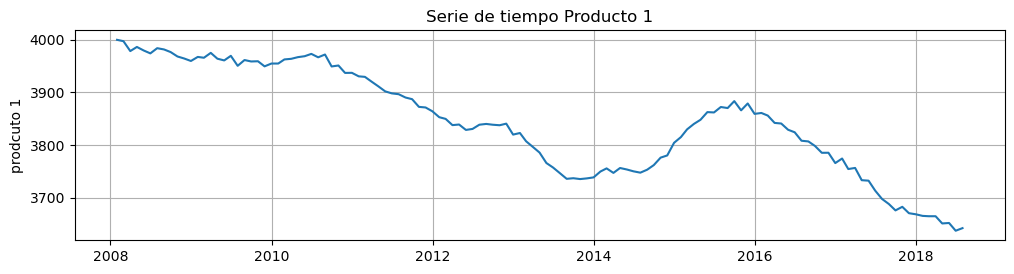

In [11]:
# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Serie de tiempo Producto 1")
plt.ylabel("prodcuto 1")
plt.plot(data["producto1"])
plt.grid()

plt.show()

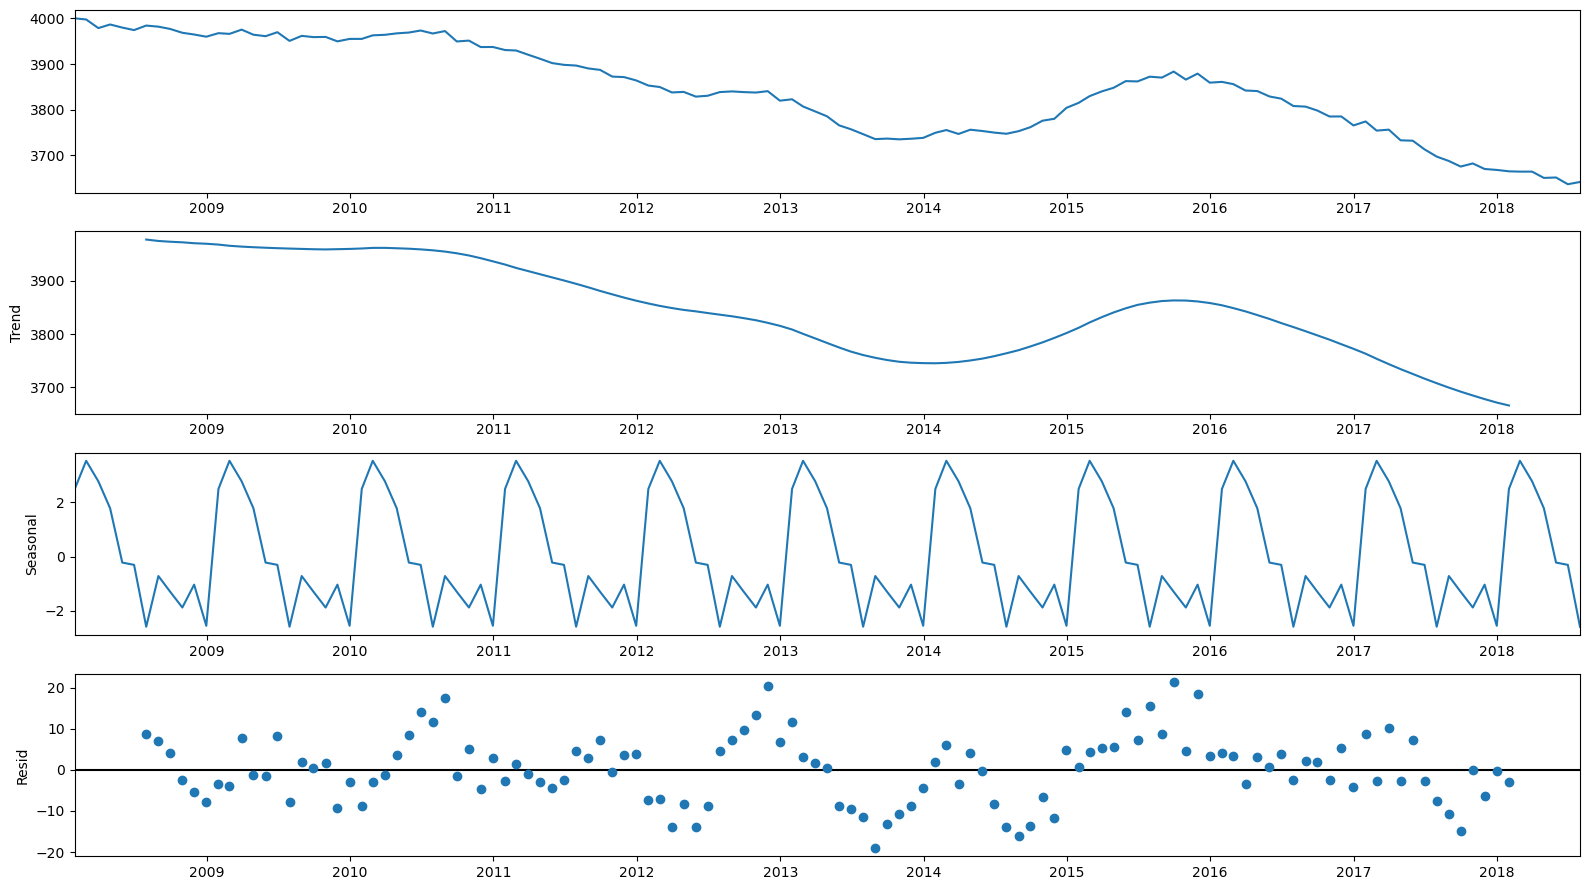

In [12]:
componentes = seasonal_decompose(data[["producto1"]],model="additive")
fig = componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

## Autocorrelacion
Autocorrelación
Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

𝐻0:ρ=0
  (Es decir no hay autocorrelación)

𝐻1:ρ≠0
  (Es decir hay autocorrelación)

Rechazo  𝐻0
  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α
 =0.05 ( α
  = nivel de significancia).

In [13]:
signo = data.producto1
runstest_1samp(signo, correction=False)

(-10.779180311358557, 4.31715564591591e-27)

Los resultados permiten rechazar la no autocorrelación (p-value=0) y por lo tanto se puede concluir que existe autocorrelación en la serie, es decir, con esta prueba la serie de productos 1 no parece comportarse como ruido blanco.

### Prueba de Box-Pierce y la modificación de Ljung-Box 

In [14]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data.producto1, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,122.203107,2.083759e-28,119.361175,8.729583e-28,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,237.486963,2.693775e-52,231.070337,6.663677e-51,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,345.694890,1.275986e-74,335.084158,2.530503e-72,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,446.232479,2.833490e-95,430.945581,5.711622e-92,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,539.298598,2.616820e-114,518.961600,6.440955e-110,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,624.725114,1.080771e-131,599.090348,3.664193e-126,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,702.281402,2.222041e-147,671.235732,1.094679e-140,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,771.886015,2.354398e-161,735.444639,1.667948e-153,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,834.016515,1.009552e-173,792.277188,9.769214e-165,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,889.132554,1.389218e-184,842.266154,1.682013e-174,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


En la serie Producto 1 es muy contundente la decisión en los primeros 20 rezagos, es decir, la serie no parece comportarse como un ruido blanco, **Si presenta autocorrelación**.

###  Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante) 

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [15]:
sm.stats.acorr_ljungbox((data.producto1-data.producto1.mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,114.121206,1.225819e-26,111.467224,4.674701e-26
2,213.657804,4.025292e-47,207.917416,7.100790e-46
3,300.504010,7.739030e-65,291.397491,7.236102e-63
4,373.966921,1.170131e-79,361.443522,5.928481e-77
5,436.725447,3.584145e-92,420.796546,9.754625e-89
6,488.830573,2.140771e-102,469.670346,2.861377e-98
7,530.480227,2.235122e-110,508.414211,1.244300e-105
8,562.164513,3.166062e-116,537.642351,5.855199e-111
9,585.434241,2.797050e-120,558.927838,1.356162e-114
10,602.102360,6.241276e-123,574.045434,6.384767e-117


Los resultados del la Tabla anterior, permiten rechazar hipotesis nula de un comportamiento homoscedástico(no auto-correlación de las varianzas) y por tanto hay comportamiento ARCH o GARCH.

### prueba de normalidad

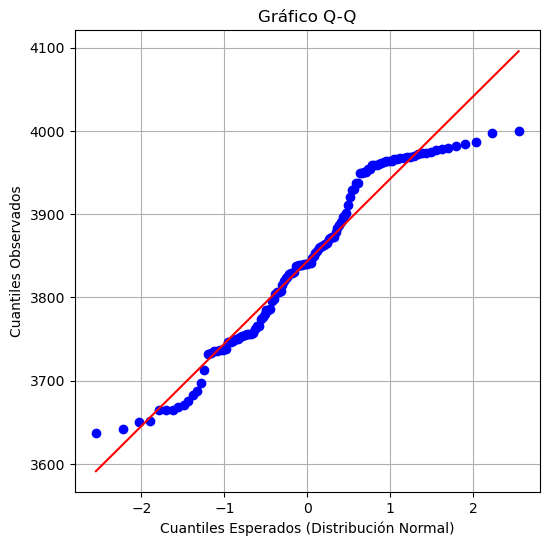

In [16]:
plt.figure(figsize=(6, 6))
stats.probplot(data.producto1, plot=plt)
plt.xlabel('Cuantiles Esperados (Distribución Normal)')
plt.ylabel('Cuantiles Observados')
plt.title('Gráfico Q-Q')
plt.grid(True)
plt.show()

In [17]:
# Realizar la prueba de Shapiro-Wilk
statistic, p_value = stats.shapiro(data.producto1)

print("Estadística de prueba:", statistic)
print("Valor p:", p_value)

# Interpretar el resultado
alpha = 0.05
if p_value > alpha:
    print("Los datos siguen una distribución normal (no se rechaza la hipótesis nula).")
else:
    print("Los datos no siguen una distribución normal (se rechaza la hipótesis nula).")

Estadística de prueba: 0.9464010000228882
Valor p: 7.399768946925178e-05
Los datos no siguen una distribución normal (se rechaza la hipótesis nula).


### Modelos predictivos prara la serie producto 1

### Tendencia Lineal

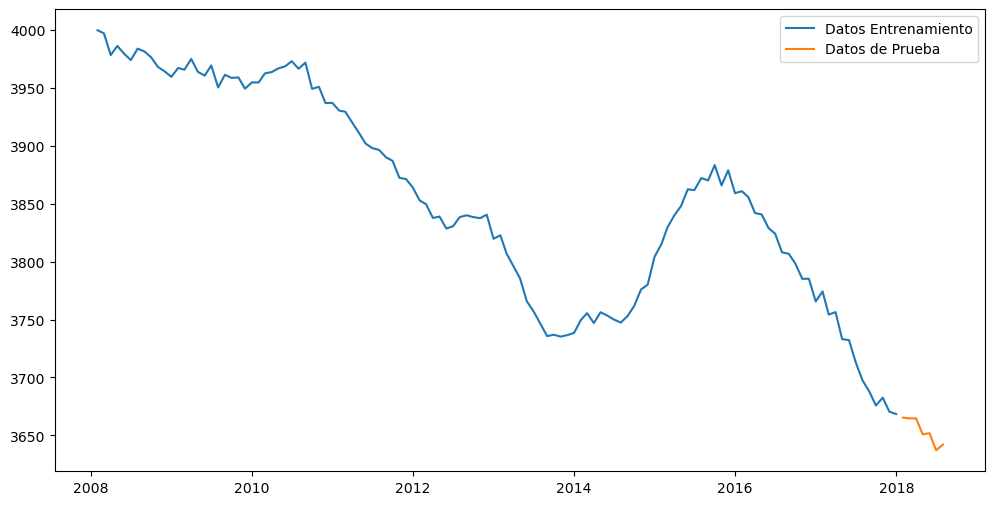

In [18]:
train_len = 127-7
train_p1 = data[["producto1"]][:train_len]
test_p1 = data[["producto1"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1,label="Datos Entrenamiento")
plt.plot(test_p1,label="Datos de Prueba")
plt.legend()
plt.show()

In [19]:
y = train_p1["producto1"]
x = np.linspace(1,train_p1.shape[0],train_p1.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:              producto1   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     305.3
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           1.60e-34
Time:                        21:07:57   Log-Likelihood:                -635.20
No. Observations:                 120   AIC:                             1274.
Df Residuals:                     118   BIC:                             1280.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3989.9247      8.921    447.229      0.0

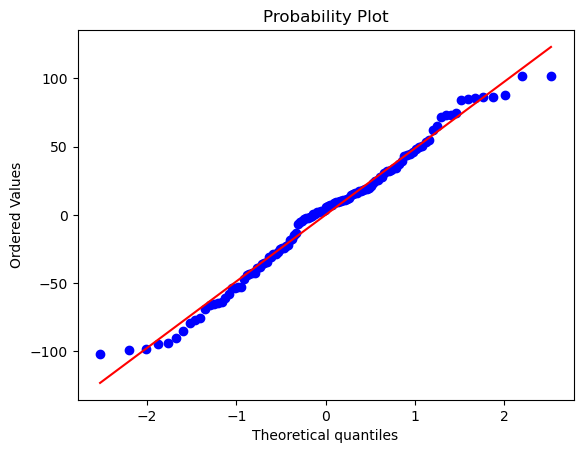

In [20]:
probplot(lin_t.resid, dist="norm", plot=plt)
plt.show()

In [21]:
bp_test = het_breuschpagan(lin_t.resid, lin_t.model.exog)

name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
print(list(zip(name, bp_test)))

if bp_test[3] < 0.05:
    print("Se rechaza H0, hay heterocedasticidad. No Cumple Supuesto")
else:
    print("No se puede rechazar H0, no hay evidencia de heterocedasticidad. Cumple supuesto")

[('Lagrange multiplier statistic', 22.838268487518793), ('p-value', 1.762216789725957e-06), ('f-value', 27.736390033158628), ('f p-value', 6.333170937009622e-07)]
Se rechaza H0, hay heterocedasticidad. No Cumple Supuesto


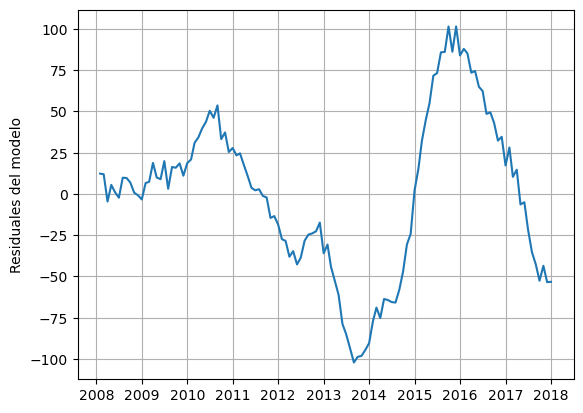

In [22]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

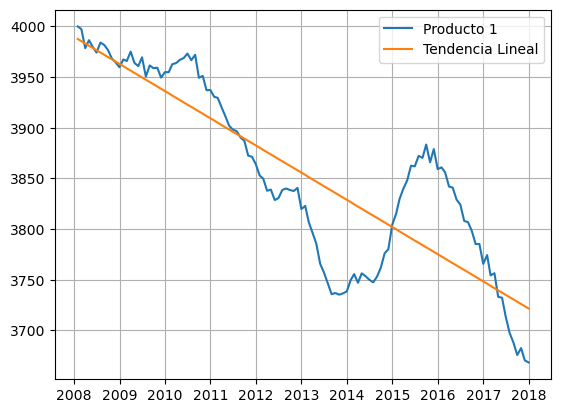

In [23]:
plt.plot(y,label="Producto 1")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [24]:
h=7
x_for= np.linspace((train_p1.shape[0]+1),(train_p1.shape[0]+h),h)
X_for= sm.add_constant(x_for)

In [25]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast     lower_95     upper_95
0     3719.364985  3621.594203  3817.135767
1     3717.128954  3619.318113  3814.939796
2     3714.892924  3617.041383  3812.744464
3     3712.656893  3614.764014  3810.549771
4     3710.420862  3612.486007  3808.355717
5     3708.184831  3610.207363  3806.162300
6     3705.948801  3607.928082  3803.969520


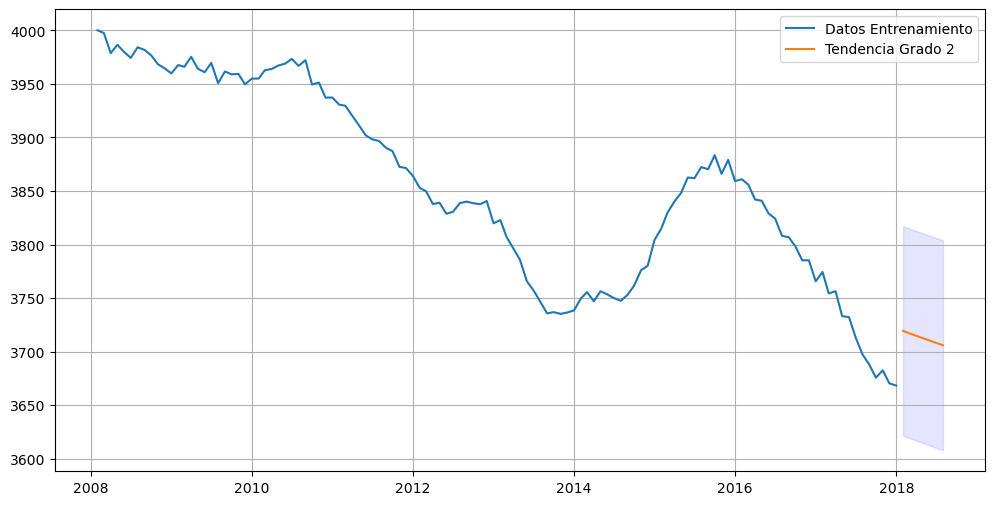

In [26]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1.index,train_p1.producto1,label="Datos Entrenamiento")
plt.plot(test_p1.index,preds['Point_forecast'],label="Tendencia Grado 2")
plt.fill_between(test_p1.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [27]:
rmse_tendencial_lineal = np.sqrt(mean_squared_error(test_p1.producto1, preds['Point_forecast']))

print(f"RMSE: {rmse_tendencial_lineal}")

RMSE: 59.30033930220065


### Polinomios

### Grado 2

In [28]:
train_len = 127-7
train_p1 = data[["producto1"]][:train_len]
test_p1 = data[["producto1"]][train_len:]

In [29]:
y = train_p1["producto1"]
z = np.linspace(1,train_p1.shape[0],train_p1.shape[0])
train_p1["z"] = z
train_p1["z2"] = z**2
X = sm.add_constant(train_p1[["z","z2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:              producto1   R-squared:                       0.741
Model:                            OLS   Adj. R-squared:                  0.737
Method:                 Least Squares   F-statistic:                     167.5
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           4.65e-35
Time:                        21:08:00   Log-Likelihood:                -630.76
No. Observations:                 120   AIC:                             1268.
Df Residuals:                     117   BIC:                             1276.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4019.3941     13.088    307.099      0.0

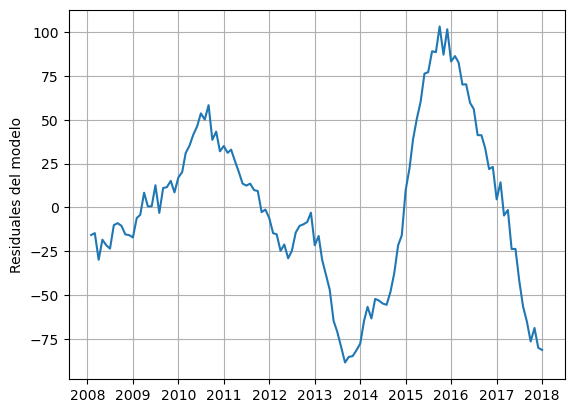

In [30]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

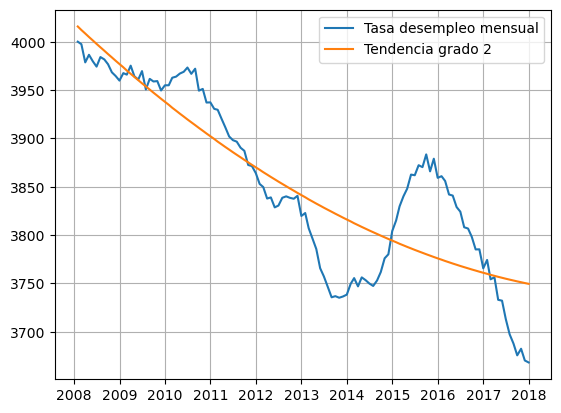

In [31]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia grado 2")
plt.legend()
plt.grid()
plt.show()

In [32]:
h=7
x_for= np.linspace((train_p1.shape[0]+1),(train_p1.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [33]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt["mean"]
yprd_ci_lower = dt["obs_ci_lower"]
yprd_ci_upper = dt["obs_ci_upper"]
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ["Point_forecast", "lower_95", "upper_95"]
print(preds)

   Point_forecast     lower_95     upper_95
0     3748.834406  3652.216901  3845.451911
1     3748.059669  3651.204888  3844.914450
2     3747.308887  3650.203687  3844.414087
3     3746.582062  3649.212923  3843.951200
4     3745.879191  3648.232218  3843.526165
5     3745.200277  3647.261200  3843.139354
6     3744.545318  3646.299498  3842.791138


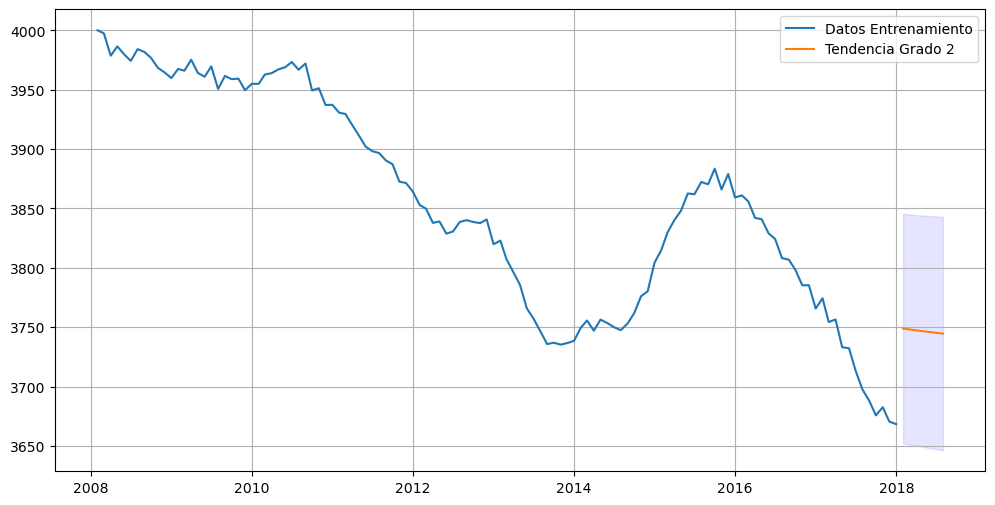

In [34]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1.index,train_p1.producto1,label="Datos Entrenamiento")
plt.plot(test_p1.index,preds['Point_forecast'],label="Tendencia Grado 2")
plt.fill_between(test_p1.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [35]:
rmse_grado2 = np.sqrt(mean_squared_error(test_p1.producto1, preds['Point_forecast']))
print(f"RMSE: {rmse_grado2}")

RMSE: 93.3568334860259


### Grado 3

In [36]:
train_len = 127-7
train_p1 = data[["producto1"]][:train_len]
test_p1 = data[["producto1"]][train_len:]

In [37]:
y = train_p1["producto1"]
z = np.linspace(1,train_p1.shape[0],train_p1.shape[0])
train_p1["z"] = z
train_p1["z2"] = z**2
train_p1["z3"] = z**3
X = sm.add_constant(train_p1[["z","z2", "z3"]])
pol = sm.OLS(y,X)
pol_3 = pol.fit()
print(pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:              producto1   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     111.7
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           4.57e-34
Time:                        21:08:02   Log-Likelihood:                -630.35
No. Observations:                 120   AIC:                             1269.
Df Residuals:                     116   BIC:                             1280.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4030.1283     17.726    227.356      0.0

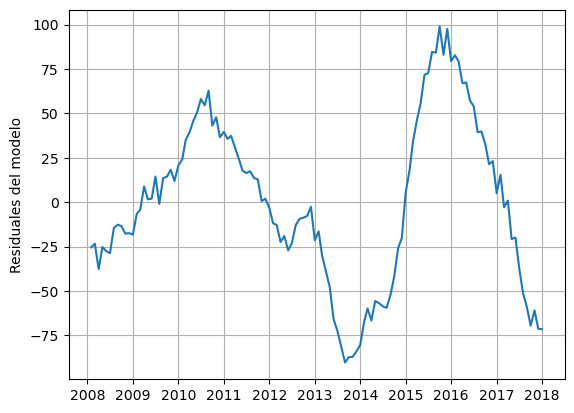

In [38]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_3.resid)
plt.grid()

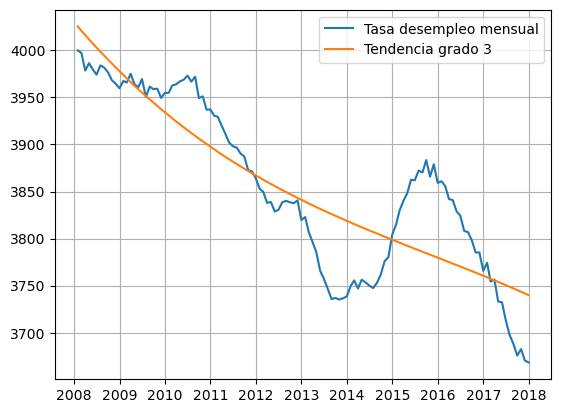

In [39]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_3.fittedvalues,label="Tendencia grado 3")
plt.legend()
plt.grid()
plt.show()

In [40]:
h=7
x_for= np.linspace((train_p1.shape[0]+1),(train_p1.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2, x_for**3), axis=1))

In [41]:
dt = pol_3.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt["mean"]
yprd_ci_lower = dt["obs_ci_lower"]
yprd_ci_upper = dt["obs_ci_upper"]
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ["Point_forecast", "lower_95", "upper_95"]
print(preds)

   Point_forecast     lower_95     upper_95
0     3738.100203  3638.543668  3837.656738
1     3736.260917  3635.891717  3836.630116
2     3734.401957  3633.132098  3835.671817
3     3732.522615  3630.258608  3834.786622
4     3730.622180  3627.265064  3833.979297
5     3728.699944  3624.145339  3833.254548
6     3726.755196  3620.893396  3832.616997


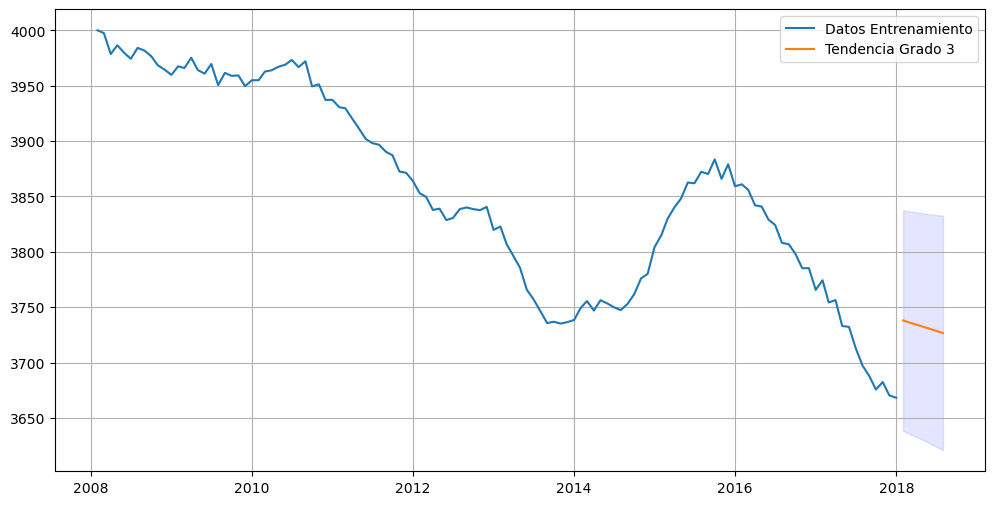

In [42]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1.index,train_p1.producto1,label="Datos Entrenamiento")
plt.plot(test_p1.index,preds['Point_forecast'],label="Tendencia Grado 3")
plt.fill_between(test_p1.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [43]:
rmse_grado3 = np.sqrt(mean_squared_error(test_p1.producto1, preds['Point_forecast']))

print(f"RMSE: {rmse_grado3}")

RMSE: 79.07602197992672


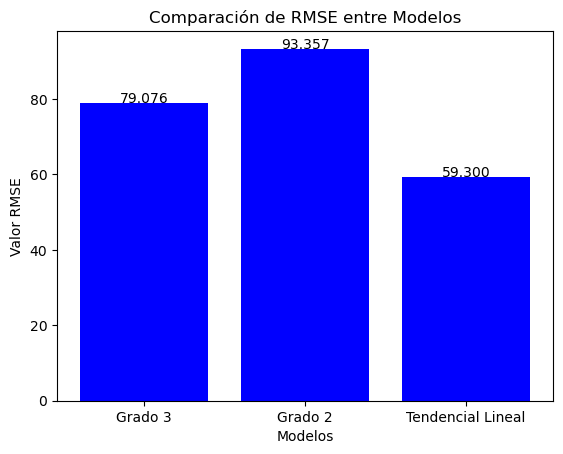

In [44]:
model_labels = ['Grado 3', 'Grado 2', 'Tendencial Lineal']
rmse_values = [rmse_grado3, rmse_grado2, rmse_tendencial_lineal]

# Crear el gráfico de barras
plt.bar(model_labels, rmse_values, color='blue')

# Agregar etiquetas y título
plt.xlabel('Modelos')
plt.ylabel('Valor RMSE')
plt.title('Comparación de RMSE entre Modelos')

# Agregar etiquetas a las barras
for i in range(len(model_labels)):
    plt.text(i, rmse_values[i] + 0.01, f'{rmse_values[i]:.3f}', ha='center')

# Mostrar el gráfico
plt.show()


### Promedio Movil

In [45]:
train_len = 127-7
train_p1 = data[["producto1"]][:train_len]
test_p1 = data[["producto1"]][train_len:]

In [46]:
## Considerando el dato actual
ma_2= train_p1.rolling(2,min_periods=2).mean()
ma_3= train_p1.rolling(3,min_periods=2).mean()
ma_4= train_p1.rolling(4,min_periods=2).mean()
ma_5= train_p1.rolling(5,min_periods=2).mean()

In [47]:
## Sin considerar el dato actual
ma_2= train_p1.shift().rolling(2,min_periods=2).mean()
ma_3= train_p1.shift().rolling(3,min_periods=2).mean()
ma_4= train_p1.shift().rolling(4,min_periods=2).mean()
ma_5= train_p1.shift().rolling(5,min_periods=2).mean()

In [48]:
def fore_ma(datos,w,h):
  data=datos.copy()
  for x in range(1,h+1):
    ind = data.index[-1]
    value = ind + pd.DateOffset(months=1)
    data.loc[value]= data[-w:].mean()
  return data[-h:] 

In [49]:
ma_2_f= fore_ma(train_p1,2,7)
ma_3_f= fore_ma(train_p1,3,7)
ma_4_f= fore_ma(train_p1,4,7)
ma_5_f= fore_ma(train_p1,5,7)

In [50]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_p1,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_p1,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_p1,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_p1,ma_5_f ))

In [51]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

18.636870455468177 20.743829135075906 21.71242721535121 23.120466326160777


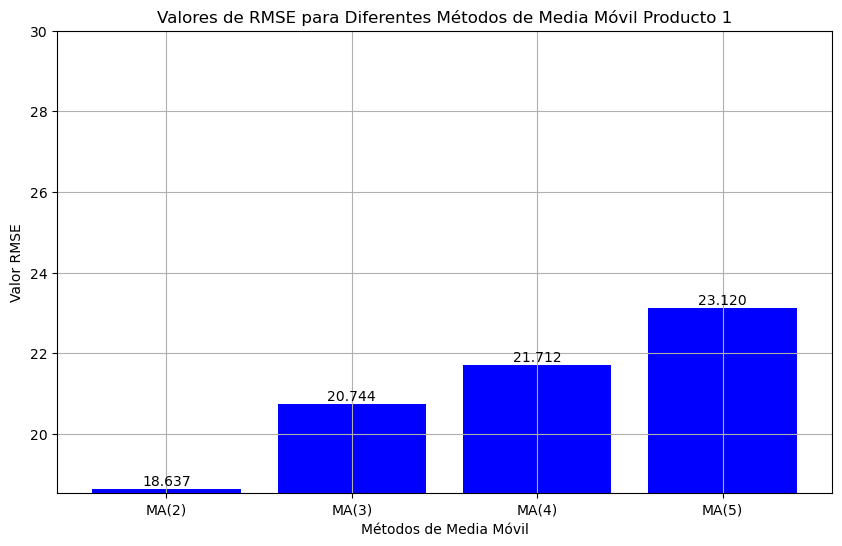

In [52]:
methods = ['MA(2)', 'MA(3)', 'MA(4)', 'MA(5)']

rmse_values = [rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, rmse_values, color='blue')
plt.xlabel('Métodos de Media Móvil')
plt.ylabel('Valor RMSE')
plt.title('Valores de RMSE para Diferentes Métodos de Media Móvil Producto 1')
plt.ylim(min(rmse_values) - 0.1, 30)  

for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{value:.3f}', ha='center', va='bottom')

plt.grid()
plt.show()

El promedio movil con el mejor RMSE es el promedio movil con una ventana de 2 (RMSE = "18.636870455468177")

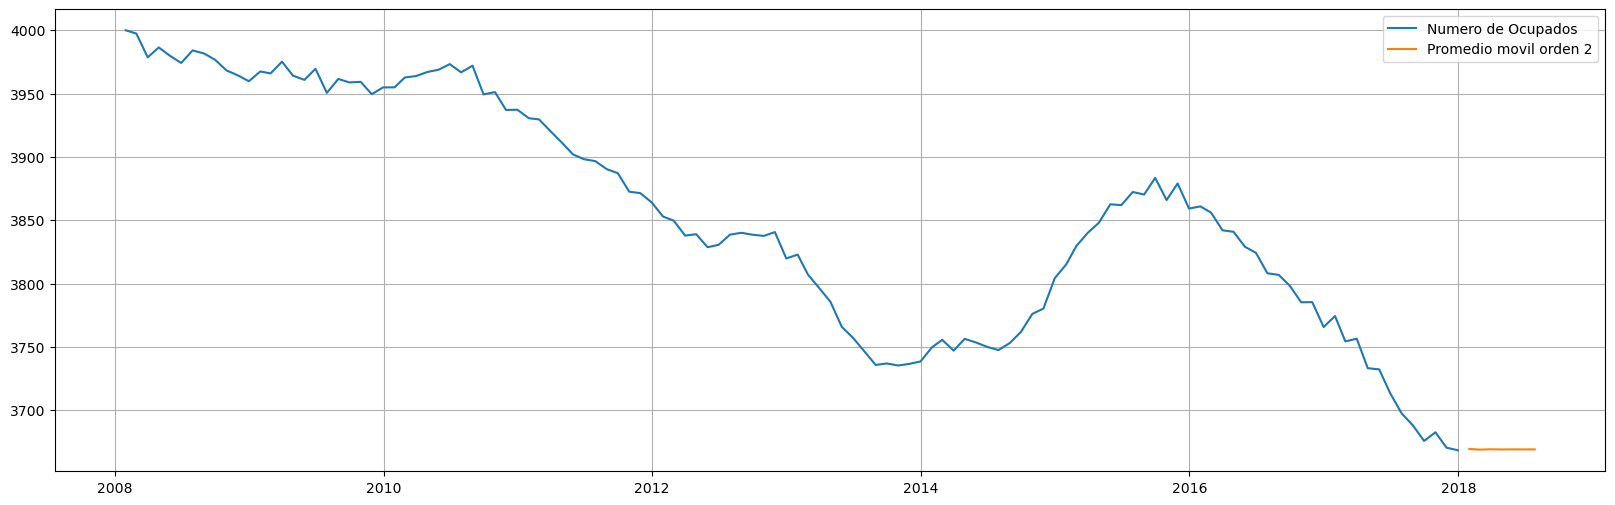

In [53]:
fig = plt.figure(figsize=(20, 6))
plt.plot(train_p1,label="Numero de Ocupados")
plt.plot(ma_2_f,label="Promedio movil orden 2")
plt.legend()
plt.grid()
plt.show()

###  Suavizacion Exponencial Simple

In [54]:
# Construccion del modelo.
ets_model = ETSModel(endog=train_p1["producto1"],error="add")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(7)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast     lower_95     upper_95
2018-01-31     3668.328631  3648.910628  3687.746635
2018-02-28     3668.328631  3640.868800  3695.788463
2018-03-31     3668.328631  3634.697905  3701.959358
2018-04-30     3668.328631  3629.495537  3707.161726
2018-05-31     3668.328631  3624.912129  3711.745134
2018-06-30     3668.328631  3620.768394  3715.888869
2018-07-31     3668.328631  3616.957826  3719.699437


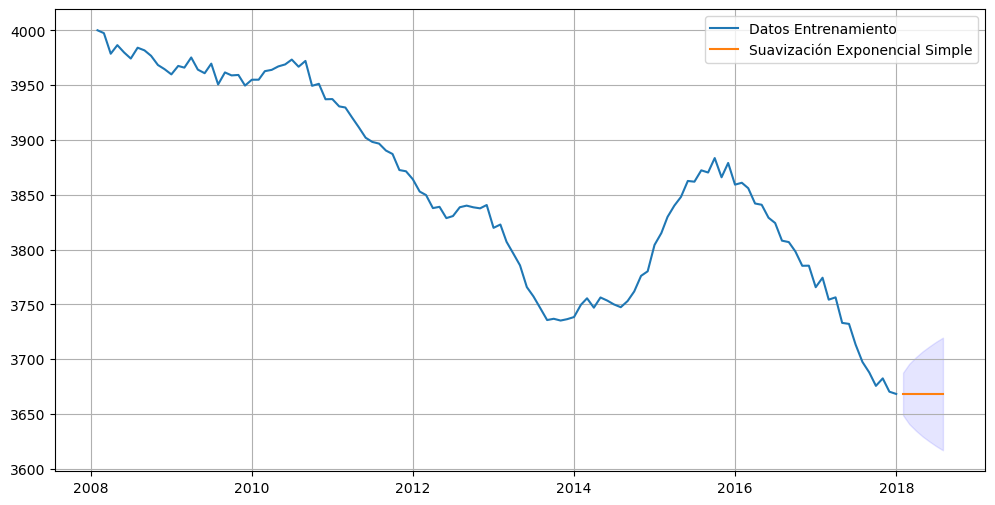

In [55]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1.producto1,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [56]:
ets_result.alpha

0.9999

In [57]:
rmse_simple = np.sqrt(mean_squared_error(test_p1,point_forecast ))
print(rmse_simple)

18.075273093521663


En esta caso el α estimado es 0.9999 y el RMSE en la muestra de evaluación es 18.075273093521663.

Este RMSE es un poco mejor al que obtuvimos con el promedio movil de 5

### Suavizacion Exponencial Lineal (Holt)

In [58]:
#Construccion del modelo.
ets_model = ETSModel(endog=train_p1["producto1"],error="mul",trend="mul")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(7)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast     lower_95     upper_95
2018-01-31     3666.537378  3651.024296  3681.048556
2018-02-28     3664.375052  3641.480185  3685.405024
2018-03-31     3662.214002  3628.260361  3694.270375
2018-04-30     3660.054226  3613.583884  3706.350707
2018-05-31     3657.895724  3597.052366  3718.381603
2018-06-30     3655.738495  3578.809817  3733.002517
2018-07-31     3653.582538  3561.109008  3752.908617


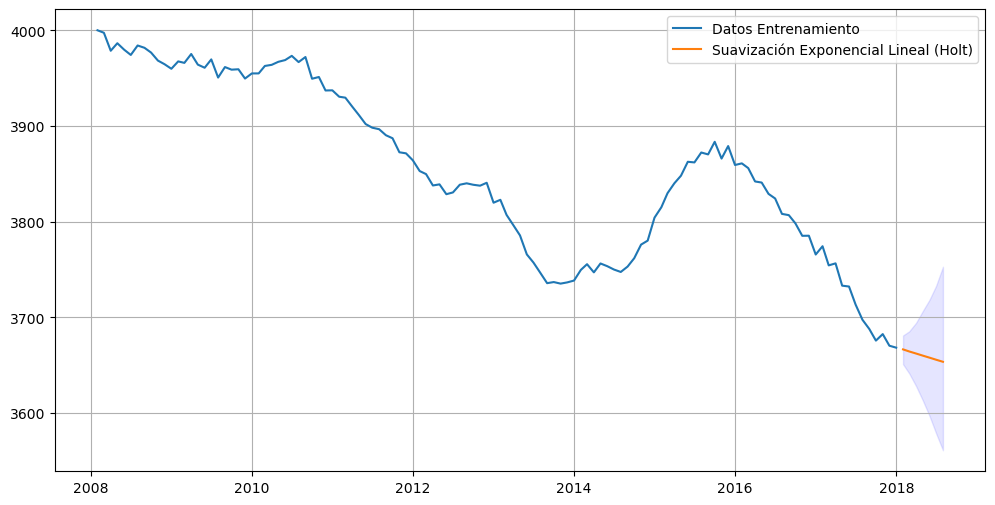

In [59]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [60]:
print(ets_result.alpha,ets_result.beta)

0.5200595746650154 0.5200075687075489


In [61]:
rmse_holt = np.sqrt(mean_squared_error(test_p1,preds_holt['Point_forecast']))
print(rmse_holt)

9.354508747611234


En esta caso el α estimado es 0.5188245044294525 y el β estimado es 0.5116907388511686. Y el RMSE en la muestra de evaluación es 9.354508747611234.

Este RMSE ha sido el mejor hasta el momento

### Suavizacion Exponencial Lineal de Winters (Holt-Winters)

In [62]:
#Construccion del modelo ADIVITVO.
ets_model = ETSModel(endog=train_p1["producto1"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(7)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast     lower_95     upper_95
2018-01-31     3672.007805  3657.048451  3686.967159
2018-02-28     3671.886554  3650.399845  3693.373263
2018-03-31     3668.715827  3637.141664  3700.289990
2018-04-30     3667.962482  3623.821052  3712.103911
2018-05-31     3664.796429  3606.185601  3723.407257
2018-06-30     3663.396566  3588.722915  3738.070217
2018-07-31     3660.595324  3568.453167  3752.737480


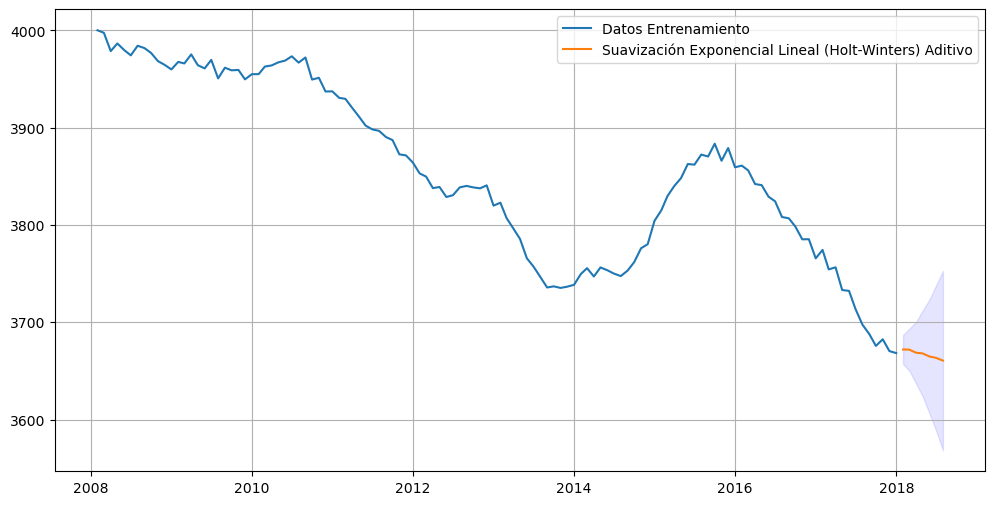

In [63]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [64]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.5155524145610336 0.5155008593195776 4.844475854389664e-05


In [65]:
rmse_hw_add = np.sqrt(mean_squared_error(test_p1,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

15.195195260970438


In [66]:
#Construccion del modelo MULTIPLICATIVO.
ets_model = ETSModel(endog=train_p1["producto1"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(7)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast     lower_95     upper_95
2018-01-31     3673.782765  3655.271046  3693.055361
2018-02-28     3674.424060  3648.640167  3702.701536
2018-03-31     3672.197504  3637.830867  3706.576278
2018-04-30     3672.377410  3633.153360  3712.283186
2018-05-31     3670.321017  3627.084971  3712.551598
2018-06-30     3670.090041  3621.010345  3719.004383
2018-07-31     3668.544910  3618.493198  3724.060748


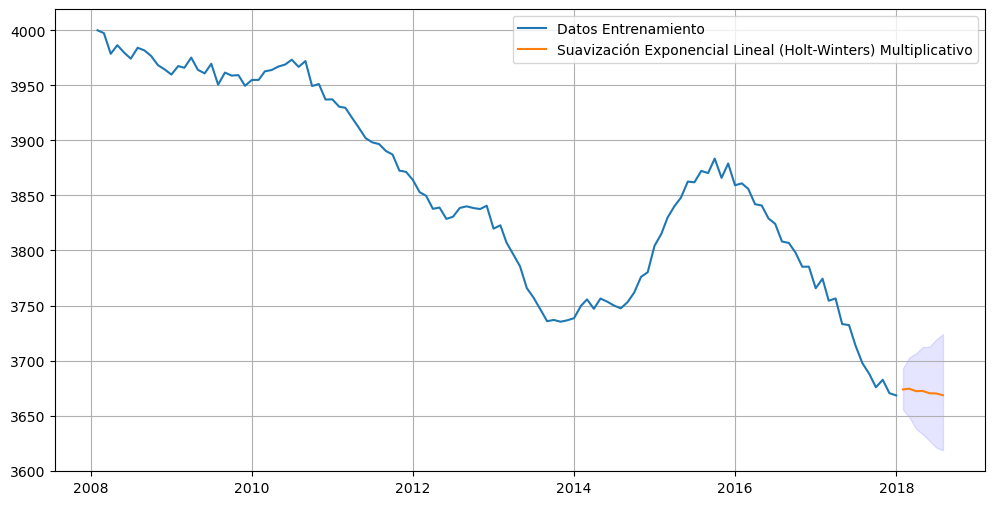

In [67]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [68]:
print(ets_result.alpha,ets_result.gamma)

0.9999 8.881462018851635e-06


In [69]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_p1,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

20.101143768918707


Podemos observar que el modelo Holt linear fue superiormente mejor

In [70]:
def train_and_evaluate_RMSE(error,trend,seasonal,alpha,beta,gamma):
    """Function we want to maximize (Black box)

    It first trains a model with the training set using the received hyper
    parameterts, and then evaluatesand returns the Min RMSE over the test set.
    """

    alpha = round(alpha,2)
    beta  = round(beta,2)
    gamma = round(gamma,2)

    print(error,trend,seasonal)
    print(alpha,beta,gamma)
    error1 = ["add","mul"]
    trend1 = ["add","mul",None]
    seasonal1 = ["add","mul",None]

    model = ETSModel(endog=train_p1["producto1"],error=error1[round(error)],trend=trend1[round(trend)],seasonal=seasonal1[round(seasonal)])

    params = {'smoothing_level': alpha,'smoothing_trend': beta,'smoothing_seasonal':gamma}

    if trend1[round(trend)] == None:
      params.pop('smoothing_trend')
    if seasonal1[round(seasonal)] == None:
      params.pop('smoothing_seasonal')

    model_result = model.fit_constrained(params)

    point_forecast=model_result.forecast(7)
    rmse = np.sqrt(mean_squared_error(test_p1["producto1"],point_forecast ))

    print(" target es: {},Eror test: {},Trend test: {},Seasonal test: {},Alpha model: {},Beta model: {}, Gamma model: {}".
          format(rmse,error1[round(error)],trend1[round(trend)],seasonal1[round(seasonal)],alpha,beta,gamma))

    return -rmse

In [71]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [72]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [73]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
0.00011437481734488664 0.1846771895375956 0.2935117816342261
0.42 0.72 0.31
 target es: 17.605596131320727,Eror test: add,Trend test: add,Seasonal test: add,Alpha model: 0.42,Beta model: 0.72, Gamma model: 0.31
| 1         | -17.61    | 0.4187    | 0.7159    | 0.0001144 | 0.3063    | 0.2935    | 0.1847    |
0.39676747423066994 1.370439000793519 0.8383890288065896
0.19 0.35 0.54
 target es: 11.416508466074529,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.19,Beta model: 0.35, Gamma model: 0.54
| 2         | -11.42    | 0.1925    | 0.3486    | 0.3968    | 0.538     | 0.8384    | 1.37      |
0.027387593197926163 1.1173796568915033 0.8346096047342539
0.21 0.87 0.67
 target es: 25.56578452761685,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.21,Beta model: 0.87, 

0.5813903458398775 1.066726313843915 0.2977197588935716
0.99 0.17 0.86
 target es: 42.631946041040116,Eror test: mul,Trend test: mul,Seasonal test: add,Alpha model: 0.99,Beta model: 0.17, Gamma model: 0.86
| 23        | -42.63    | 0.99      | 0.1675    | 0.5814    | 0.8601    | 0.2977    | 1.067     |
0.22189897392220517 1.6098605265862005 1.205112170294335
0.01 0.25 0.12
 target es: 166.49642026005702,Eror test: add,Trend test: None,Seasonal test: mul,Alpha model: 0.01,Beta model: 0.25, Gamma model: 0.12
| 24        | -166.5    | 0.01      | 0.2549    | 0.2219    | 0.119     | 1.205     | 1.61      |
0.0 1.1411421813735536 0.6903257774703392
0.45 0.2 0.87
 target es: 8.78914552224745,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.45,Beta model: 0.2, Gamma model: 0.87
| 25        | -8.789    | 0.446     | 0.1952    | 0.0       | 0.866     | 0.6903    | 1.141     |
0.8110396677477442 1.4241358595007716 1.7520329159770418
0.48 0.76 0.78
 target es: 4.343123172569471,Er

1.0 0.5039617797279662 1.5032788289756027
0.99 0.99 0.01
 target es: 8.384742125516551,Eror test: mul,Trend test: mul,Seasonal test: None,Alpha model: 0.99,Beta model: 0.99, Gamma model: 0.01
| 46        | -8.385    | 0.99      | 0.99      | 1.0       | 0.01      | 1.503     | 0.504     |
1.0 1.2234966269750713 2.0
0.34 0.18 0.99
 target es: 18.38768579011282,Eror test: mul,Trend test: mul,Seasonal test: None,Alpha model: 0.34,Beta model: 0.18, Gamma model: 0.99
| 47        | -18.39    | 0.3411    | 0.183     | 1.0       | 0.99      | 2.0       | 1.223     |
0.40023299864164685 0.49802772568400777 1.007815053437854
0.92 0.77 0.02
 target es: 6.098477559787779,Eror test: add,Trend test: add,Seasonal test: mul,Alpha model: 0.92,Beta model: 0.77, Gamma model: 0.02
| 48        | -6.098    | 0.9243    | 0.7714    | 0.4002    | 0.02447   | 1.008     | 0.498     |
0.557780040941746 0.1691028460400011 1.5002379555953305
0.99 0.36 0.01
 target es: 9.273751179842671,Eror test: mul,Trend test: ad

0.886611060092204 0.0 0.8433293661176787
0.99 0.99 0.01
 target es: 16.117255398214613,Eror test: mul,Trend test: add,Seasonal test: mul,Alpha model: 0.99,Beta model: 0.99, Gamma model: 0.01
| 69        | -16.12    | 0.99      | 0.99      | 0.8866    | 0.01      | 0.8433    | 0.0       |
0.0 1.226386008713004 1.5174792592934299
0.99 0.99 0.99
 target es: 8.384742125516551,Eror test: add,Trend test: mul,Seasonal test: None,Alpha model: 0.99,Beta model: 0.99, Gamma model: 0.99
| 70        | -8.385    | 0.99      | 0.99      | 0.0       | 0.99      | 1.517     | 1.226     |
0.0 0.38802327716293517 2.0
0.99 0.99 0.99
 target es: 8.36412375067706,Eror test: add,Trend test: add,Seasonal test: None,Alpha model: 0.99,Beta model: 0.99, Gamma model: 0.99
| 71        | -8.364    | 0.99      | 0.99      | 0.0       | 0.99      | 2.0       | 0.388     |
0.25150183672163007 1.6226382670764996 1.5594727865738023
0.04 0.03 0.59
 target es: 125.32902265125533,Eror test: add,Trend test: None,Seasonal te

0.7586390310177874 1.4293148438115493 1.7714799687207852
0.52 0.74 0.82
 target es: 4.403861059333449,Eror test: mul,Trend test: mul,Seasonal test: None,Alpha model: 0.52,Beta model: 0.74, Gamma model: 0.82
| 93        | -4.404    | 0.5176    | 0.7392    | 0.7586    | 0.8176    | 1.771     | 1.429     |
1.0 0.5197839549940806 0.0
0.99 0.84 0.01
 target es: 20.85901974094495,Eror test: mul,Trend test: mul,Seasonal test: add,Alpha model: 0.99,Beta model: 0.84, Gamma model: 0.01
| 94        | -20.86    | 0.99      | 0.8383    | 1.0       | 0.01      | 0.0       | 0.5198    |
0.5929523255865321 0.3494404547220664 0.43346710238518305
0.54 0.64 0.36
 target es: 15.246734174460418,Eror test: mul,Trend test: add,Seasonal test: add,Alpha model: 0.54,Beta model: 0.64, Gamma model: 0.36
| 95        | -15.25    | 0.5361    | 0.6403    | 0.593     | 0.3562    | 0.4335    | 0.3494    |
0.9588713948823138 0.09165083102369254 0.7699552864726107
0.94 0.12 0.42
 target es: 16.03675948413434,Eror test: m

In [74]:
optimal_values = optimizer.max
print("Valor RMSE:", -optimal_values['target'])
print("Parámetros óptimos:", optimal_values['params'])

Valor RMSE: 4.343123172569471
Parámetros óptimos: {'alpha': 0.4837360314529422, 'beta': 0.7551741073278718, 'error': 0.8110396677477442, 'gamma': 0.775371228724769, 'seasonal': 1.7520329159770418, 'trend': 1.4241358595007716}


In [75]:
rmse_Optimizado=-optimal_values['target']

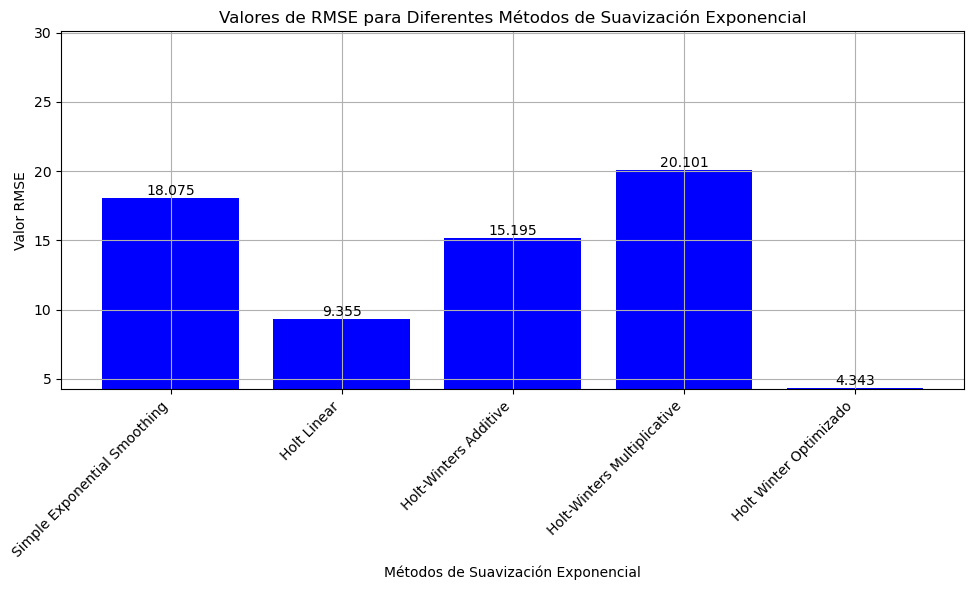

In [78]:
# Nombres de los métodos
methods = ['Simple Exponential Smoothing', 'Holt Linear', 'Holt-Winters Additive', 'Holt-Winters Multiplicative', 'Holt Winter Optimizado']

# Valores RMSE correspondientes
rmse_values = [rmse_simple, rmse_holt, rmse_hw_add, rmse_hw_mul, rmse_Optimizado]

# Crear el gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, rmse_values, color='blue')
plt.xlabel('Métodos de Suavización Exponencial')
plt.ylabel('Valor RMSE')
plt.title('Valores de RMSE para Diferentes Métodos de Suavización Exponencial')
plt.ylim(min(rmse_values) - 0.1, max(rmse_values) + 10)

# Agregar los valores encima de las barras
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{value:.3f}', ha='center', va='bottom')

# Rotar los nombres de los métodos en el eje x para mayor legibilidad
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.grid()
plt.tight_layout()  # Ajustar el diseño
plt.show()


In [79]:
train_len = 127-7
train_p1 = data[["producto1"]][:train_len]
test_p1 = data[["producto1"]][train_len:]

### Auto arima

In [80]:
model = auto_arima(train_p1["producto1"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -405.290
Date:                Tue, 29 Aug 2023   AIC                            822.579
Time:                        21:18:03   BIC                            839.254
Sample:                    01-31-2008   HQIC                           829.351
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.9545      0.663     -1.439      0.150      -2.255       0.346
ar.L1          0.3010      0.138      2.177      0.029       0.030       0.572
ar.L2          0.3910      0.146      2.670      0.008       0.104       0.678
ma.L1         -0.4678      0.132     -3.555      0.000      -0.726      -0.210
ma.L2          0.3529      0.130      2.709      0.007       0.098       0.608
sigma2        52.6025      7.783      6.759      0.000      37.349      67.856
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.98
Prob(Q):                              0.99   Prob(JB):                         0.61
Heteroskedasticity (H):               0.98   Skew:                            -0.12
Prob(H) (two-sided):                  0.95   Kurtosis:                         2.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

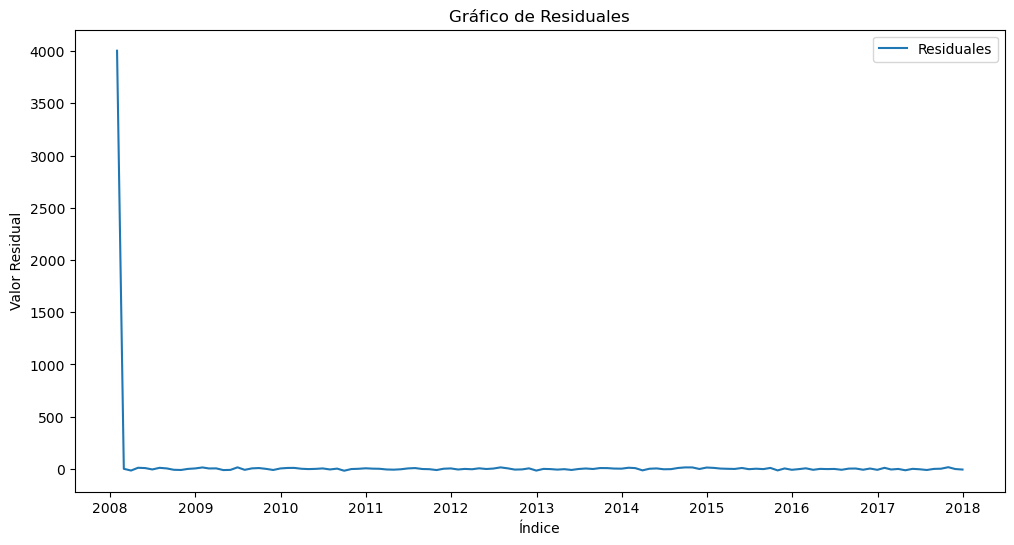

In [81]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid(), label="Residuales")

plt.legend()
plt.xlabel('Índice')
plt.ylabel('Valor Residual')
plt.title('Gráfico de Residuales')
plt.show()

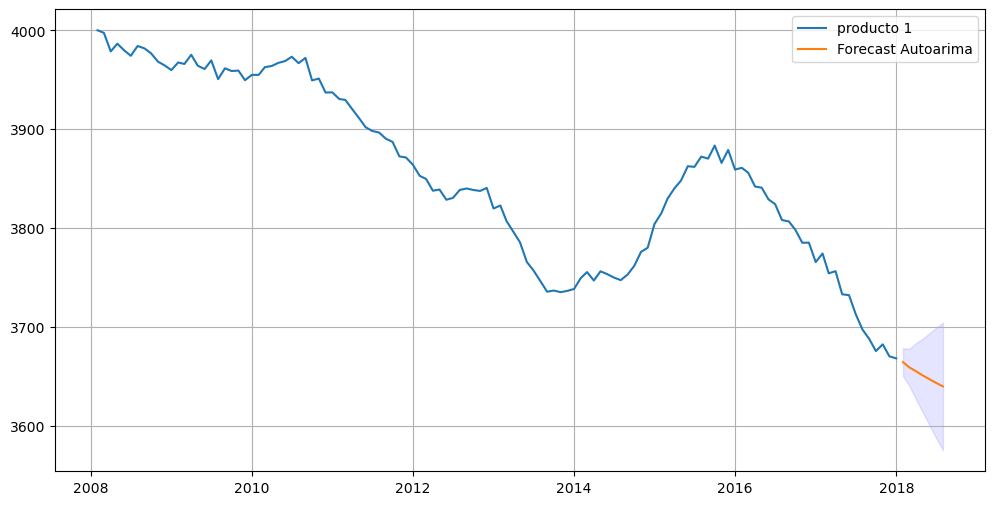

In [82]:
h=7

y_forec, conf_int  = model.predict(h,return_conf_int=True,alpha=0.05)
preds = pd.DataFrame(np.column_stack([y_forec,conf_int[:,0] , conf_int[:,1]]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']

fig = plt.figure(figsize=(12, 6))
plt.plot(train_p1.index,train_p1["producto1"],label="producto 1")
plt.plot(test_p1.index,preds['Point_forecast'],label="Forecast Autoarima")
plt.fill_between(test_p1.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [83]:
rmse_autoarima = np.sqrt(mean_squared_error(test_p1["producto1"], preds["Point_forecast"]))

In [84]:
rmse_autoarima

5.111136690946883

## Probar el modelo arima

In [85]:
window_size = 120  # Tamaño de la ventana de entrenamiento y pronóstico
forecast_steps = 1  # Número de pasos de pronóstico

for i in range(0, 7):
    # Definir los conjuntos de entrenamiento y prueba
    train_subset = train_p1["producto1"][:i+window_size]
    test_subset = test_p1["producto1"][i:i+forecast_steps]  # Corregir la selección del conjunto de prueba
    # Ajustar el modelo SARIMA con los órdenes y valores estacionales definidos
    model = SARIMAX(train_subset, order=(2, 1, 2), seasonal_order=model.seasonal_order)
    model_fit = model.fit()
    
    # Realizar pronósticos
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Calcular el RMSE
    rmse = mean_squared_error(test_subset, forecast, squared=False)
    print(f"Pronostico {i+1}: RMSE = {rmse}")

Pronostico 1: RMSE = 0.09598048425687011
Pronostico 2: RMSE = 0.5531473656928938
Pronostico 3: RMSE = 0.5678479327830246
Pronostico 4: RMSE = 14.296779733413132
Pronostico 5: RMSE = 13.390149418093188
Pronostico 6: RMSE = 28.130979645733078
Pronostico 7: RMSE = 23.18774638656305


## Validacion de supuestos para modelo arima

## Autocorrelacion
Autocorrelación
Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

𝐻0:ρ=0
  (Es decir no hay autocorrelación)

𝐻1:ρ≠0
  (Es decir hay autocorrelación)

Rechazo  𝐻0
  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α
 =0.05 ( α
  = nivel de significancia).

In [86]:
result = model.fit()
residuals = result.resid
runstest_1samp(residuals[1:], correction=False)

(0.46111029858961317, 0.6447194733780724)

Se puede concluir que No existe autocorrelación en los residuales

### Prueba de Box-Pierce y la modificación de Ljung-Box 

In [87]:
Resul_lb_bp = sm.stats.acorr_ljungbox(residuals[1:], lags=range(1,20), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,0.058672,0.808607,0.057217,0.810949,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,0.184115,0.912053,0.178513,0.914611,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,0.220125,0.974277,0.213035,0.975458,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,0.220391,0.994357,0.213289,0.994702,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
5,0.411807,0.994998,0.393630,0.995503,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
6,0.794163,0.992229,0.750707,0.993331,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
7,3.190451,0.866843,2.968758,0.887877,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
8,3.231957,0.918969,3.006835,0.933928,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
9,3.392164,0.946701,3.152477,0.957941,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
10,8.395964,0.590219,7.660033,0.662005,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr


In [88]:
residuales = residuals[1:]

durbin_watson_statistic = durbin_watson(residuales)

print(f"Estadístico de Durbin-Watson: {durbin_watson_statistic}")


Estadístico de Durbin-Watson: 2.010042592512759


Para el Producto 1 se evidencia una No autocorrelacion en los residuales por lo tanto si se cumple el supuesto

###  Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante) 

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [89]:
sm.stats.acorr_ljungbox((residuales[1:]-residuales[1:].mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.740102,0.389628,0.721599,0.395620
2,1.225292,0.541915,1.190616,0.551393
3,1.954048,0.581999,1.889007,0.595760
4,3.809282,0.432432,3.651480,0.455222
5,3.914967,0.561723,3.751000,0.585793
6,4.055406,0.669178,3.882077,0.692631
7,4.137139,0.763853,3.957679,0.784639
8,5.168780,0.739394,4.903350,0.767855
9,5.769281,0.762769,5.448805,0.793563
10,8.448713,0.585094,7.860294,0.642481


Los resultados del la Tabla anterior, permiten rechazar hipotesis nula de un comportamiento homoscedástico(no auto-correlación de las varianzas) y por tanto hay comportamiento ARCH o GARCH.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


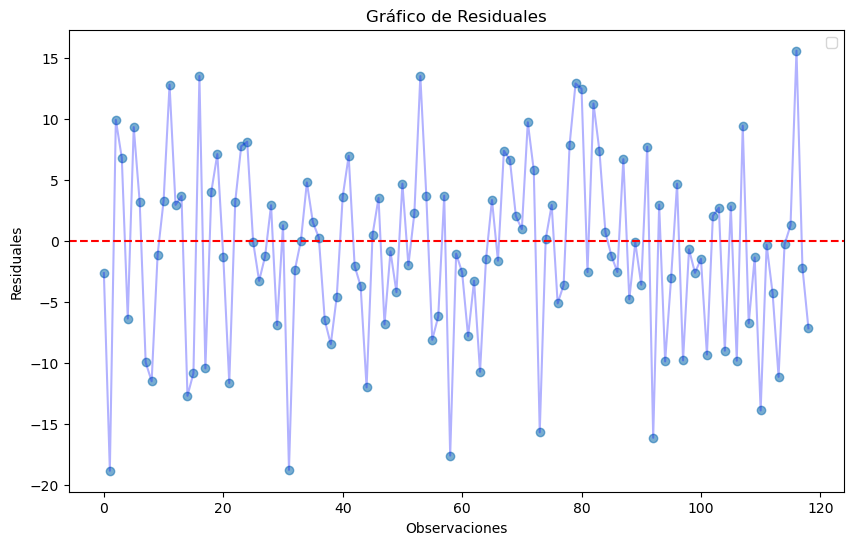

In [90]:
residuales = residuals[1:]

# Crear un gráfico de dispersión de los residuales
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuales)), residuales, alpha=0.6)
plt.plot(range(len(residuales)), residuales, 'b-', alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de Residuales')
plt.xlabel('Observaciones')
plt.ylabel('Residuales')
plt.legend()
plt.show()


### prueba de normalidad

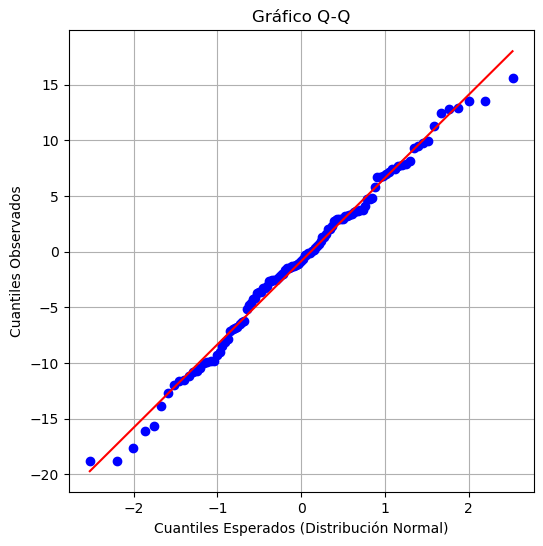

In [91]:
residuales = residuals[1:]

plt.figure(figsize=(6, 6))
stats.probplot(residuales, plot=plt)
plt.xlabel('Cuantiles Esperados (Distribución Normal)')
plt.ylabel('Cuantiles Observados')
plt.title('Gráfico Q-Q')
plt.grid(True)
plt.show()

In [92]:
# Realizar la prueba de Shapiro-Wilk
statistic, p_value = stats.shapiro(residuales)

print("Estadística de prueba:", statistic)
print("Valor p:", p_value)

# Interpretar el resultado
alpha = 0.05
if p_value > alpha:
    print("Los datos siguen una distribución normal (no se rechaza la hipótesis nula).")
else:
    print("Los datos no siguen una distribución normal (se rechaza la hipótesis nula).")

Estadística de prueba: 0.9892891049385071
Valor p: 0.47932812571525574
Los datos siguen una distribución normal (no se rechaza la hipótesis nula).


### Estacionalidad + tendencia

In [93]:
train_len = 127-7
train_p1 = data[["producto1"]][:train_len]
test_p1 = data[["producto1"]][train_len:]

In [94]:
y = train_p1["producto1"]
train_p1["q"] = np.linspace(1,train_p1.shape[0],train_p1.shape[0])
train_p1["q2"] = train_p1["q"]**2
train_p1["q3"] = train_p1["q"]**3

month_dummies = pd.get_dummies(train_p1.index.month,drop_first=True).set_index(train_p1.index)
X = sm.add_constant( pd.concat([train_p1[["q","q2","q3"]],month_dummies],axis=1) )

season_pol3 = sm.OLS(y,X)
season_pol_3 = season_pol3.fit()
print(season_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:              producto1   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.710
Method:                 Least Squares   F-statistic:                     21.80
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           6.42e-25
Time:                        21:18:07   Log-Likelihood:                -630.08
No. Observations:                 120   AIC:                             1290.
Df Residuals:                     105   BIC:                             1332.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4033.2814     23.161    174.143      0.0

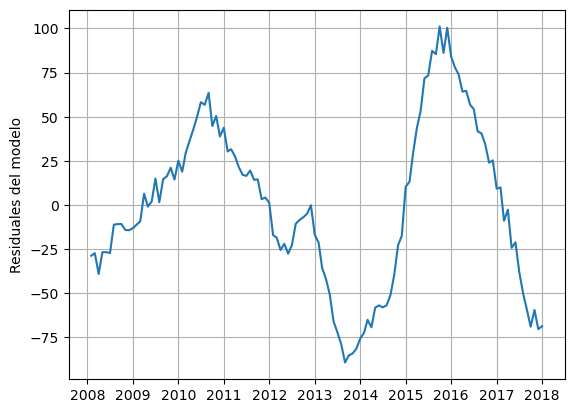

In [95]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_3.resid)
plt.grid()

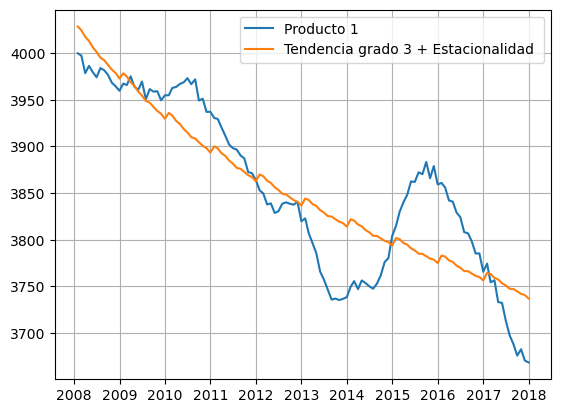

In [96]:
plt.plot(y,label="Producto 1")
plt.plot(season_pol_3.fittedvalues,label="Tendencia grado 3 + Estacionalidad ")
plt.legend()
plt.grid()

In [97]:
h=12
x_for= np.linspace((train_p1.shape[0]+1),(train_p1.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2, x_for**3),axis=1),columns=["x","x2", "x3"] )

range_dates = pd.date_range(train_p1.index[-1]+ relativedelta(months=1), periods=h,freq='M')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

,const,x,x2,x3,2,3,4,5,6,7,8,9,10,11,12
0,1.0,121.0,14641.0,1771561.0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,122.0,14884.0,1815848.0,1,0,0,0,0,0,0,0,0,0,0
2,1.0,123.0,15129.0,1860867.0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,124.0,15376.0,1906624.0,0,0,1,0,0,0,0,0,0,0,0
4,1.0,125.0,15625.0,1953125.0,0,0,0,1,0,0,0,0,0,0,0
5,1.0,126.0,15876.0,2000376.0,0,0,0,0,1,0,0,0,0,0,0
6,1.0,127.0,16129.0,2048383.0,0,0,0,0,0,1,0,0,0,0,0
7,1.0,128.0,16384.0,2097152.0,0,0,0,0,0,0,1,0,0,0,0
8,1.0,129.0,16641.0,2146689.0,0,0,0,0,0,0,0,1,0,0,0
9,1.0,130.0,16900.0,2197000.0,0,0,0,0,0,0,0,0,1,0,0


In [98]:
dt = season_pol_3.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds.head(7))

            Point_forecast     lower_95     upper_95
2018-01-31     3744.774592  3635.279343  3854.269842
2018-02-28     3743.507803  3633.261685  3853.753921
2018-03-31     3739.221801  3628.148600  3850.295002
2018-04-30     3737.378628  3625.397383  3849.359873
2018-05-31     3733.154339  3620.179344  3846.129335
2018-06-30     3730.719401  3616.660238  3844.778564
2018-07-31     3726.912943  3611.674556  3842.151329


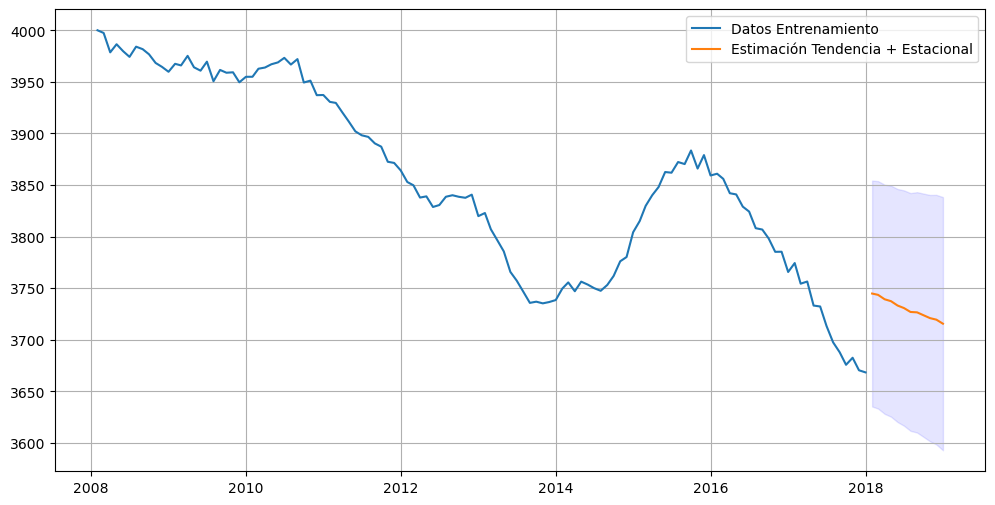

In [99]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [100]:
rmse_S_T = np.sqrt(mean_squared_error(test_p1, preds.Point_forecast.head(7)))
rmse_S_T

82.97825274577526

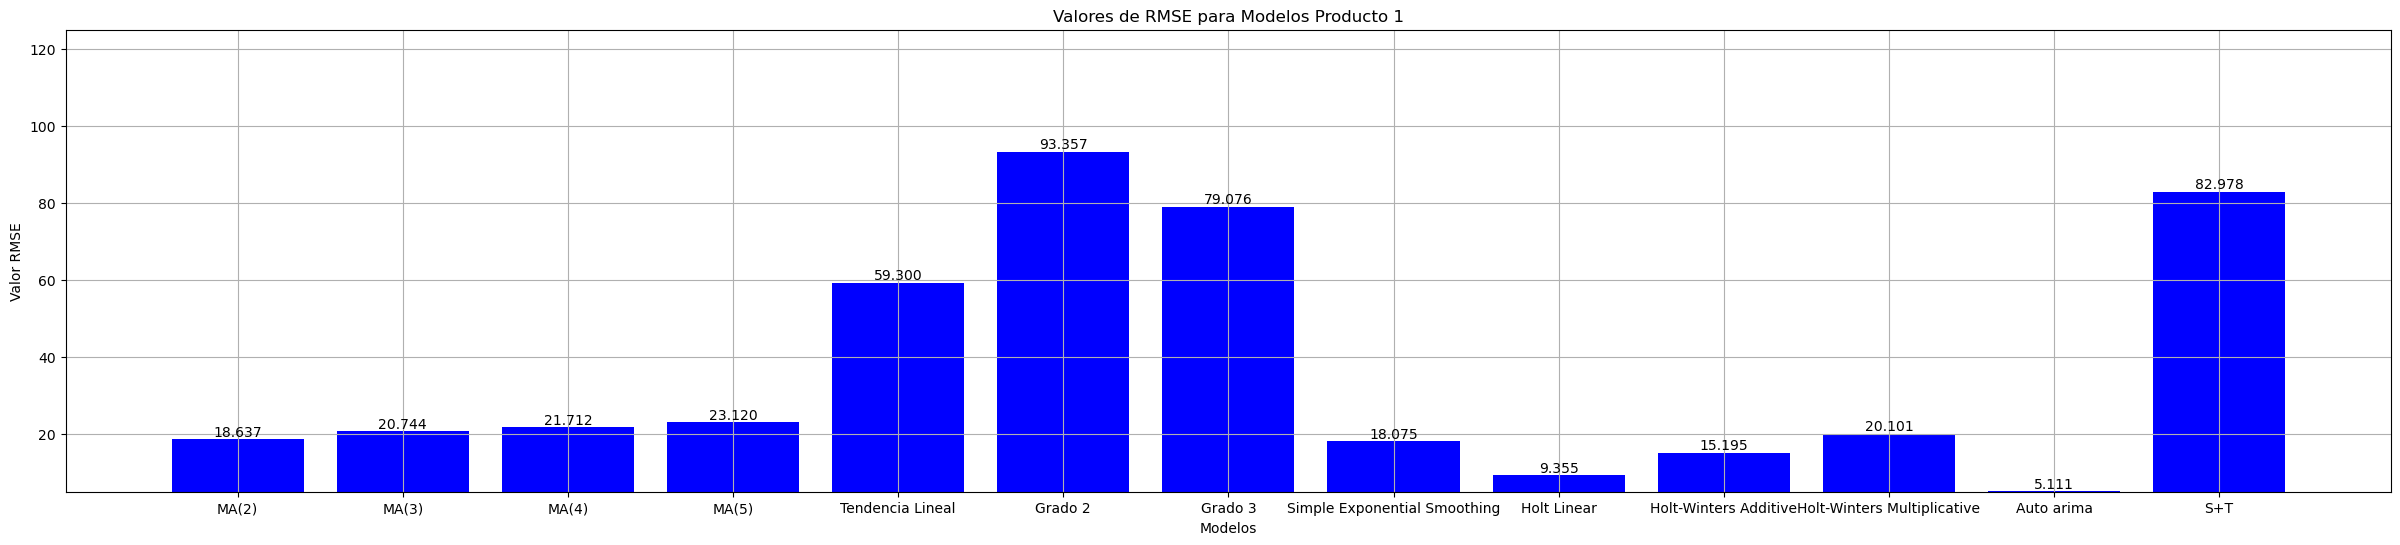

In [101]:
methods = ['MA(2)', 'MA(3)', 'MA(4)', 'MA(5)', 'Tendencia Lineal', 'Grado 2', 'Grado 3', 'Simple Exponential Smoothing', 'Holt Linear', 'Holt-Winters Additive', 'Holt-Winters Multiplicative', 'Auto arima', 'S+T']

rmse_values = [rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5, rmse_tendencial_lineal, rmse_grado2, rmse_grado3, rmse_simple, rmse_holt, rmse_hw_add, rmse_hw_mul, rmse_autoarima, rmse_S_T  ]

plt.figure(figsize=(30, 6))
bars = plt.bar(methods, rmse_values, color='blue')
plt.xlabel('Modelos')
plt.ylabel('Valor RMSE')
plt.title('Valores de RMSE para Modelos Producto 1')
plt.ylim(min(rmse_values) - 0.1, 125)  

for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{value:.3f}', ha='center', va='bottom')

plt.grid()
plt.show()

## Serie producto 2

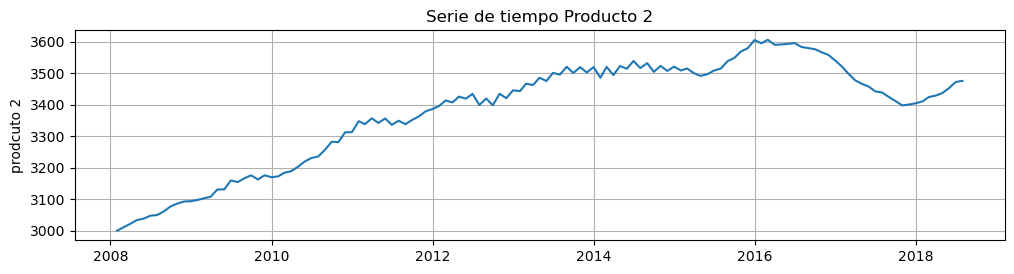

In [102]:
# Graficando los datos
fig = plt.figure(figsize=(12, 6))

plt.subplot(2,1, 1)
plt.title("Serie de tiempo Producto 2")
plt.ylabel("prodcuto 2")
plt.plot(data["producto2"])
plt.grid()

plt.show()

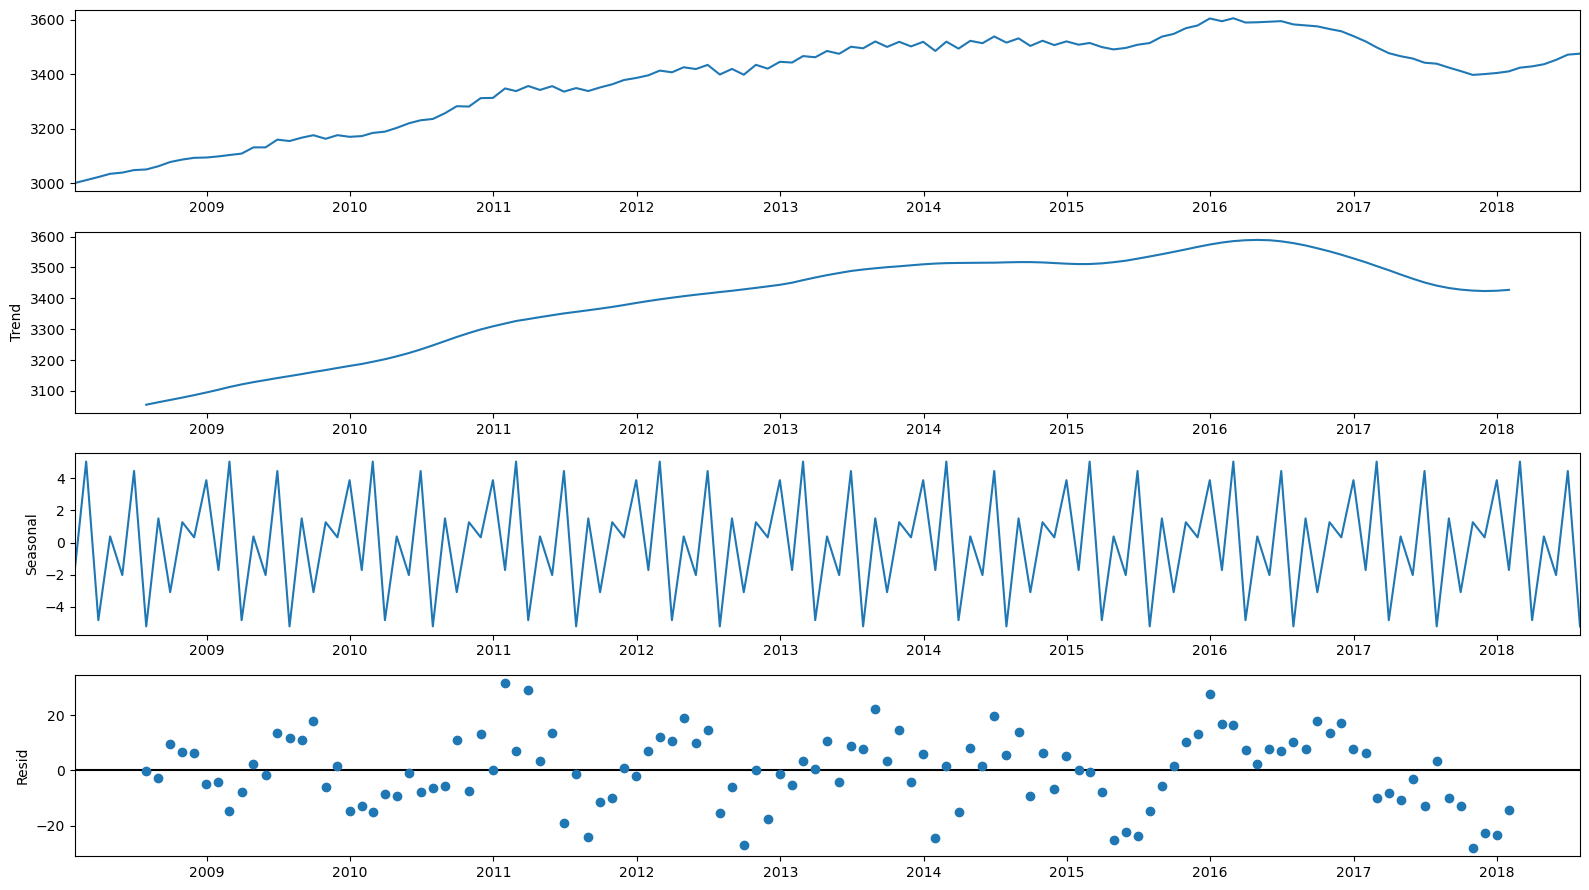

In [103]:
componentes = seasonal_decompose(data[["producto2"]],model="additive")
fig = componentes.plot()
fig.set_size_inches((16, 9))
fig.tight_layout()
plt.show()

## Autocorrelacion
Autocorrelación
Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

𝐻0:ρ=0
  (Es decir no hay autocorrelación)

𝐻1:ρ≠0
  (Es decir hay autocorrelación)

Rechazo  𝐻0
  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α
 =0.05 ( α
  = nivel de significancia).

In [104]:
signo = data.producto2
runstest_1samp(signo, correction=False)

(-11.129783217479355, 8.985375985449134e-29)

Los resultados permiten rechazar la no autocorrelación (p-value=0) y por lo tanto se puede concluir que existe autocorrelación en la serie, es decir, con esta prueba la serie de producto2 no parece comportarse como ruido blanco.

### Prueba de Box-Pierce y la modificación de Ljung-Box 

In [105]:
Resul_lb_bp = sm.stats.acorr_ljungbox(data.producto2, lags=range(1,21), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,123.254838,1.226409e-28,120.388447,5.201076e-28,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,241.757761,3.183972e-53,235.216860,8.381232e-52,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,354.239891,1.801336e-76,343.339218,4.129499e-74,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,461.807685,1.216308e-98,445.903858,3.337047e-95,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,563.370513,1.655648e-119,541.955525,6.982631e-115,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,659.914186,2.754055e-139,632.511994,2.257146e-133,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,750.621017,8.356274e-158,716.890441,1.573007e-150,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,836.489298,2.804889e-175,796.102266,1.424072e-166,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,917.200763,1.216413e-191,869.931358,1.858894e-181,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,993.576163,4.525378e-207,939.202070,2.318857e-195,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


En la serie Producto 2 es muy contundente la decisión en los primeros 20 rezagos, es decir, la serie no parece comportarse como un ruido blanco, **Si presenta autocorrelación**.

###  Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante) 

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [106]:
sm.stats.acorr_ljungbox((data.producto2-data.producto2.mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,114.651469,9.381910e-27,111.985156,3.599954e-26
2,217.273364,6.602196e-48,211.424977,1.229277e-46
3,307.115997,2.868185e-66,297.785337,2.999706e-64
4,386.343939,2.481225e-82,373.328258,1.607607e-79
5,454.367297,5.612920e-96,437.660426,2.252912e-92
6,512.885621,1.408123e-107,492.549707,3.384754e-103
7,561.453005,4.842084e-117,537.728669,6.165976e-112
8,601.971307,8.818883e-125,575.106017,5.246339e-119
9,635.355609,5.375123e-131,605.643595,1.287380e-124
10,662.996135,5.485136e-136,630.712910,4.602072e-129


Los resultados del la Tabla anterior, permiten rechazar hipotesis nula de un comportamiento homoscedástico(no auto-correlación de las varianzas) y por tanto hay comportamiento ARCH o GARCH.

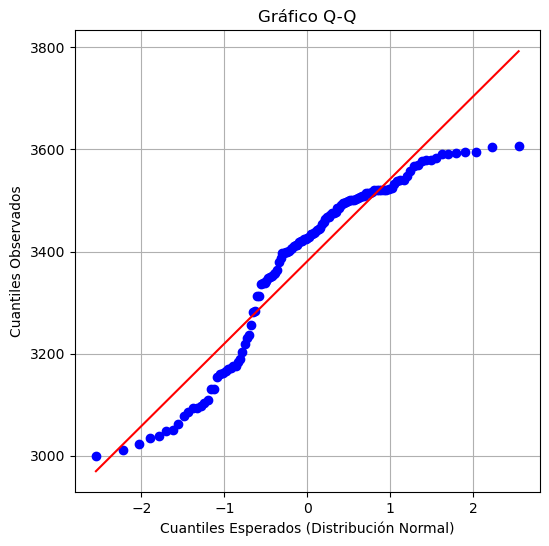

In [107]:
plt.figure(figsize=(6, 6))
stats.probplot(data.producto2, plot=plt)
plt.xlabel('Cuantiles Esperados (Distribución Normal)')
plt.ylabel('Cuantiles Observados')
plt.title('Gráfico Q-Q')
plt.grid(True)
plt.show()

In [108]:
# Realizar la prueba de Shapiro-Wilk
statistic, p_value = stats.shapiro(data.producto2)

print("Estadística de prueba:", statistic)
print("Valor p:", p_value)

# Interpretar el resultado
alpha = 0.05
if p_value > alpha:
    print("Los datos siguen una distribución normal (no se rechaza la hipótesis nula).")
else:
    print("Los datos no siguen una distribución normal (se rechaza la hipótesis nula).")

Estadística de prueba: 0.9012953042984009
Valor p: 1.1921981979412521e-07
Los datos no siguen una distribución normal (se rechaza la hipótesis nula).


### Modelos predictivos prara la serie producto 2

### Tendencia Lineal

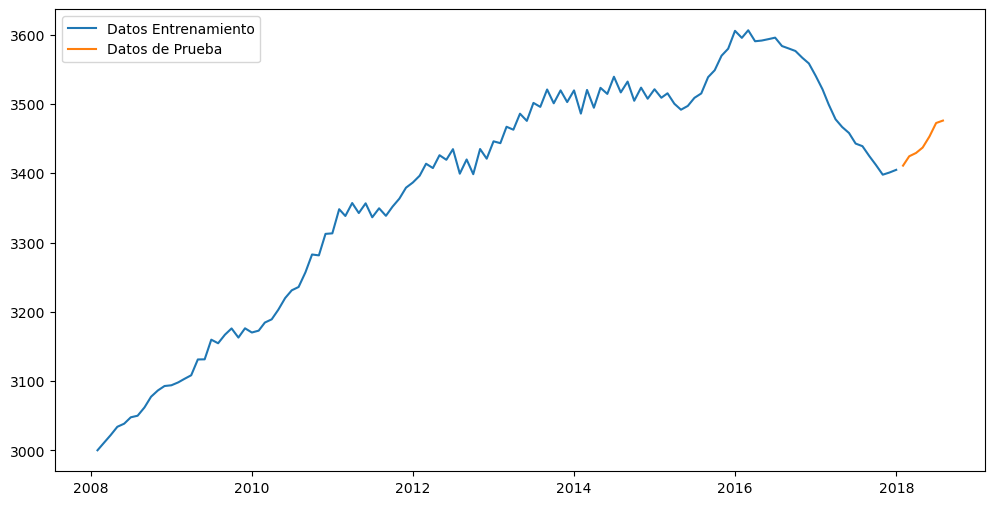

In [109]:
train_len = 127-7
train_p2 = data[["producto2"]][:train_len]
test_p2 = data[["producto2"]][train_len:]

fig = plt.figure(figsize=(12, 6))
plt.plot(train_p2,label="Datos Entrenamiento")
plt.plot(test_p2,label="Datos de Prueba")
plt.legend()
plt.show()

In [110]:
y = train_p2["producto2"]
x = np.linspace(1,train_p2.shape[0],train_p2.shape[0])
X = sm.add_constant(x)
lin = sm.OLS(y,X)
lin_t = lin.fit()
print(lin_t.summary())

                            OLS Regression Results                            
Dep. Variable:              producto2   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     410.2
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           3.28e-40
Time:                        21:18:13   Log-Likelihood:                -697.24
No. Observations:                 120   AIC:                             1398.
Df Residuals:                     118   BIC:                             1404.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3114.4382     14.962    208.162      0.0

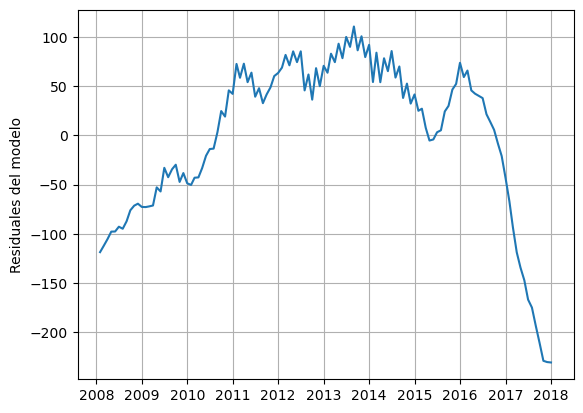

In [111]:
plt.ylabel("Residuales del modelo")
plt.plot(lin_t.resid)
plt.grid()

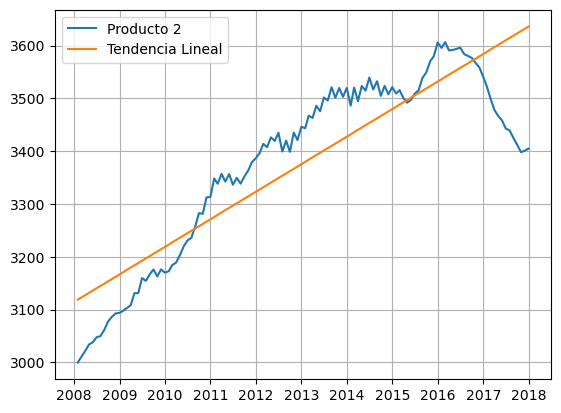

In [112]:
plt.plot(y,label="Producto 2")
plt.plot(lin_t.fittedvalues,label="Tendencia Lineal")
plt.legend()
plt.grid()
plt.show()

In [113]:
h=7
x_for= np.linspace((train_p2.shape[0]+1),(train_p2.shape[0]+h),h)
X_for= sm.add_constant(x_for)

In [114]:
dt = lin_t.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

   Point_forecast     lower_95     upper_95
0     3640.364314  3476.399081  3804.329547
1     3644.710811  3480.678398  3808.743225
2     3649.057308  3484.956641  3813.157975
3     3653.403805  3489.233812  3817.573798
4     3657.750302  3493.509913  3821.990690
5     3662.096799  3497.784945  3826.408652
6     3666.443296  3502.058910  3830.827682


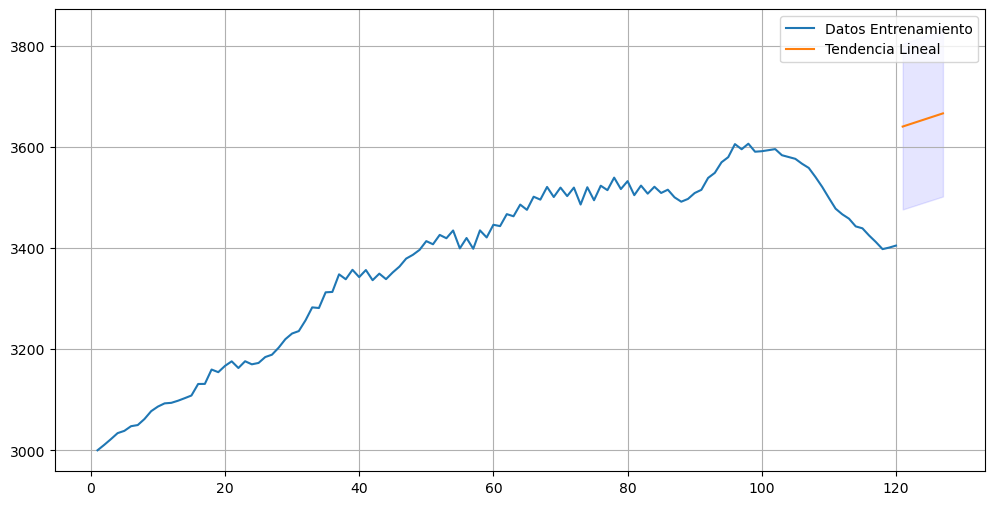

In [115]:
fig = plt.figure(figsize=(12, 6))
plt.plot(x,y,label="Datos Entrenamiento")
plt.plot(x_for,preds['Point_forecast'],label="Tendencia Lineal")
plt.fill_between(x_for ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [116]:
rmse_tendencial_lineal = np.sqrt(mean_squared_error(test_p2.producto2, preds['Point_forecast']))

print(f"RMSE: {rmse_tendencial_lineal}")

RMSE: 210.5187119177325


### Polinomios

### Grado 2

In [187]:
train_len = 127-7
train_p2 = data[["producto2"]][:train_len]
test_p2 = data[["producto2"]][train_len:]

In [188]:
y = train_p2["producto2"]
z = np.linspace(1,train_p2.shape[0],train_p2.shape[0])
train_p1["z"] = z
train_p1["z2"] = z**2
X = sm.add_constant(train_p1[["z","z2"]])
pol = sm.OLS(y,X)
pol_2 = pol.fit()
print(pol_2.summary())

                            OLS Regression Results                            
Dep. Variable:              producto2   R-squared:                       0.960
Model:                            OLS   Adj. R-squared:                  0.959
Method:                 Least Squares   F-statistic:                     1404.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           1.65e-82
Time:                        21:43:33   Log-Likelihood:                -594.03
No. Observations:                 120   AIC:                             1194.
Df Residuals:                     117   BIC:                             1202.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       2946.6824      9.637    305.776      0.0

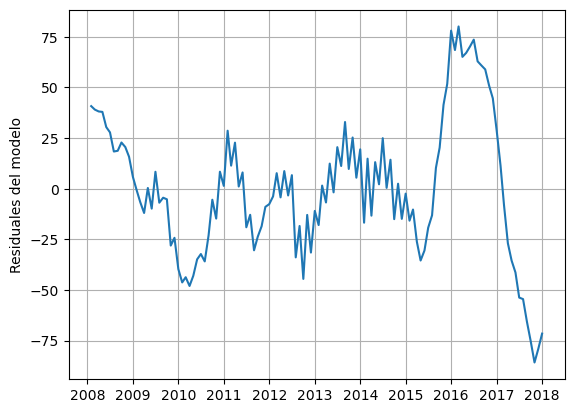

In [189]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_2.resid)
plt.grid()

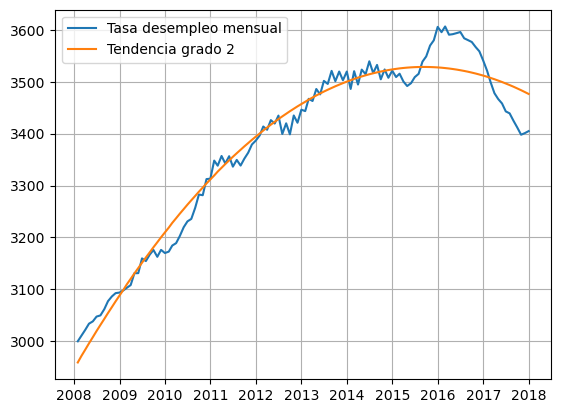

In [120]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_2.fittedvalues,label="Tendencia grado 2")
plt.legend()
plt.grid()
plt.show()

In [190]:
h=7
x_for= np.linspace((train_p2.shape[0]+1),(train_p2.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2), axis=1))

In [191]:
dt = pol_2.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt["mean"]
yprd_ci_lower = dt["obs_ci_lower"]
yprd_ci_upper = dt["obs_ci_upper"]
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ["Point_forecast", "lower_95", "upper_95"]
print(preds)

   Point_forecast     lower_95     upper_95
0     3472.608572  3401.470165  3543.746978
1     3468.636602  3397.323492  3539.949713
2     3464.528264  3393.030773  3536.025755
3     3460.283558  3388.591732  3531.975384
4     3455.902483  3384.006091  3527.798876
5     3451.385041  3379.273575  3523.496506
6     3446.731229  3374.393912  3519.068547


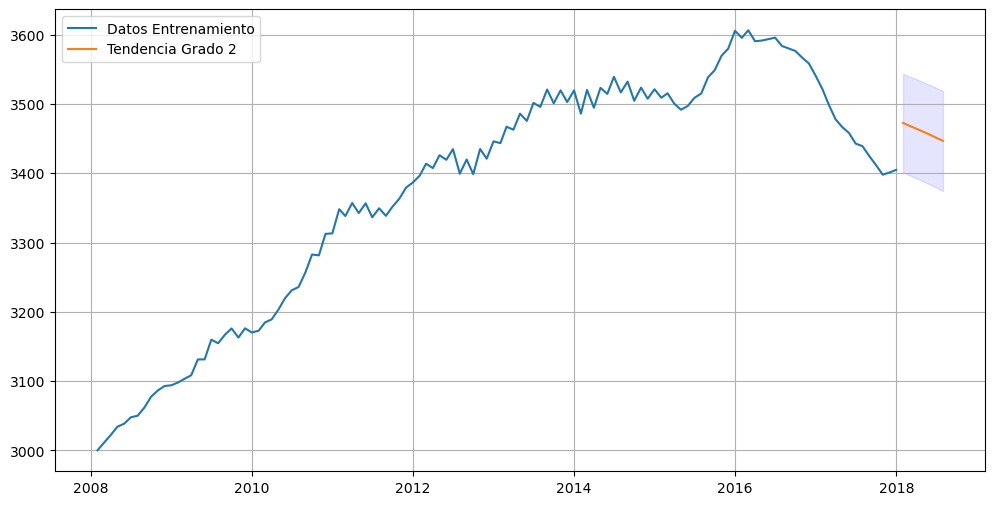

In [192]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p2.index,train_p2.producto2,label="Datos Entrenamiento")
plt.plot(test_p2.index,preds['Point_forecast'],label="Tendencia Grado 2")
plt.fill_between(test_p2.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [193]:
rmse_grado2 = np.sqrt(mean_squared_error(test_p2.producto2, preds['Point_forecast']))

print(f"RMSE: {rmse_grado2}")

RMSE: 35.53165510678264


## validacion de supuestos

In [194]:
Resul_lb_bp = sm.stats.acorr_ljungbox(pol_2.resid, lags=range(1,20), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,95.187771,1.731567e-22,92.847088,5.649488e-22,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
2,185.271814,5.871333e-41,179.977556,8.286483e-40,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
3,242.217774,3.154306e-52,234.589665,1.407459e-50,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
4,287.150714,6.398953e-61,277.312789,8.459679e-59,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
5,308.924436,1.207032e-64,297.837198,2.921652e-62,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
6,323.068744,9.276635e-67,311.054011,3.496601e-64,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
7,326.501746,1.313016e-66,314.233759,5.506914e-64,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
8,327.521024,5.651576e-66,315.169489,2.423818e-63,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
9,327.958473,3.021001e-65,315.567496,1.296109e-62,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr
10,329.840159,7.509302e-65,317.264098,3.462172e-62,rechazo_ho/hay_autocorr,rechazo_ho/hay_autocorr


Existe correlacion en los residuales no se cumple supuesto

###  Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante) 

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [196]:
sm.stats.acorr_ljungbox((pol_2.resid-pol_2.resid.mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,95.897330,1.209984e-22,93.539199,3.982349e-22
2,172.494510,3.493760e-38,167.624996,3.987444e-37
3,218.116084,5.128090e-47,211.376833,1.467617e-45
4,247.077577,2.773898e-52,238.913991,1.589711e-50
5,263.159392,8.236689e-55,254.073078,7.346942e-53
6,272.186864,7.385840e-56,262.508585,8.685592e-54
7,276.352017,6.734399e-56,266.366473,9.056703e-54
8,278.145440,1.830043e-55,268.012893,2.598506e-53
9,279.189575,6.715816e-55,268.962886,9.805974e-53
10,279.890702,2.745557e-54,269.595049,4.070781e-52


Los resultados del la Tabla anterior, permiten rechazar la hipotesis nula de un comportamiento homoscedástico

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


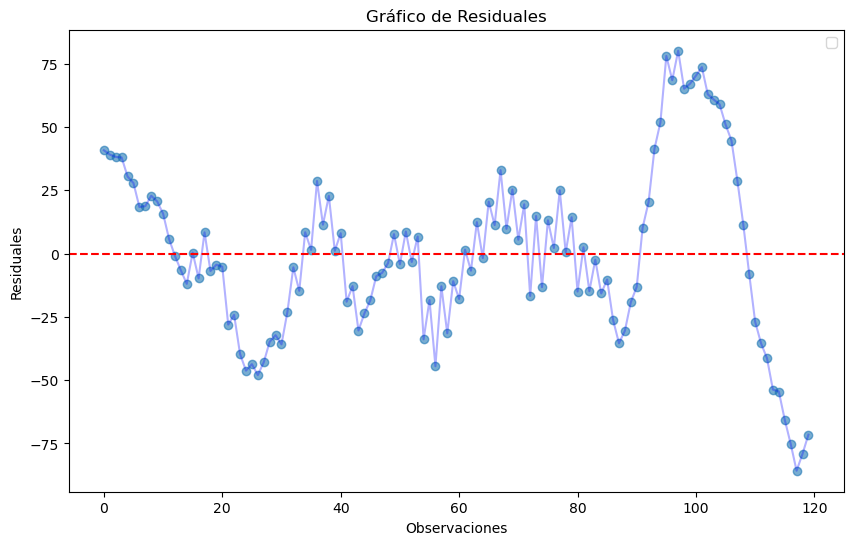

In [200]:

residuals = pol_2.resid

# Crear un gráfico de dispersión de los residuales
plt.figure(figsize=(10, 6))
plt.scatter(range(len(pol_2.resid)), pol_2.resid, alpha=0.6)
plt.plot(range(len(pol_2.resid)), pol_2.resid, 'b-', alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de Residuales')
plt.xlabel('Observaciones')
plt.ylabel('Residuales')
plt.legend()
plt.show()


Se puede comprobar que los valores tienen varianza contasnte

### prueba de normalidad

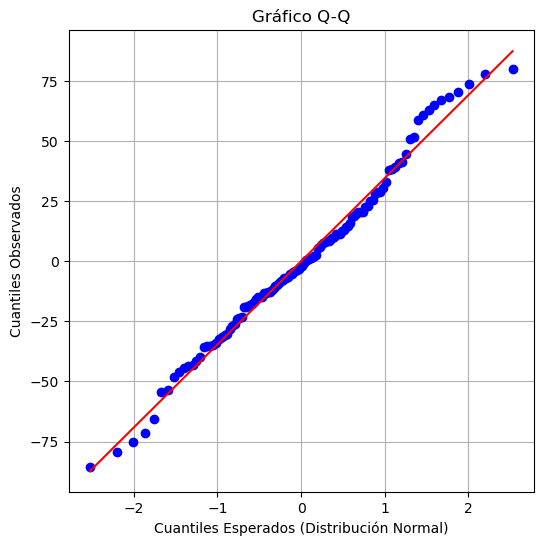

In [198]:
plt.figure(figsize=(6, 6))
stats.probplot(pol_2.resid, plot=plt)
plt.xlabel('Cuantiles Esperados (Distribución Normal)')
plt.ylabel('Cuantiles Observados')
plt.title('Gráfico Q-Q')
plt.grid(True)
plt.show()

In [199]:
statistic, p_value = stats.shapiro(pol_2.resid)

print("Estadística de prueba:", statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("Los datos siguen una distribución normal (no se rechaza la hipótesis nula).")
else:
    print("Los datos no siguen una distribución normal (se rechaza la hipótesis nula).")

Estadística de prueba: 0.986980140209198
Valor p: 0.3067573606967926
Los datos siguen una distribución normal (no se rechaza la hipótesis nula).


Se cumple supuesto de normalidad

### Grado 3

In [125]:
train_len = 127-7
train_p2 = data[["producto2"]][:train_len]
test_p2 = data[["producto2"]][train_len:]

In [126]:
y = train_p2["producto2"]
z = np.linspace(1,train_p2.shape[0],train_p2.shape[0])
train_p1["z"] = z
train_p1["z2"] = z**2
train_p1["z3"] = z**3
X = sm.add_constant(train_p1[["z","z2", "z3"]])
pol = sm.OLS(y,X)
pol_3 = pol.fit()
print(pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:              producto2   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.974
Method:                 Least Squares   F-statistic:                     1484.
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           2.57e-92
Time:                        21:18:16   Log-Likelihood:                -566.78
No. Observations:                 120   AIC:                             1142.
Df Residuals:                     116   BIC:                             1153.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3004.0962     10.437    287.837      0.0

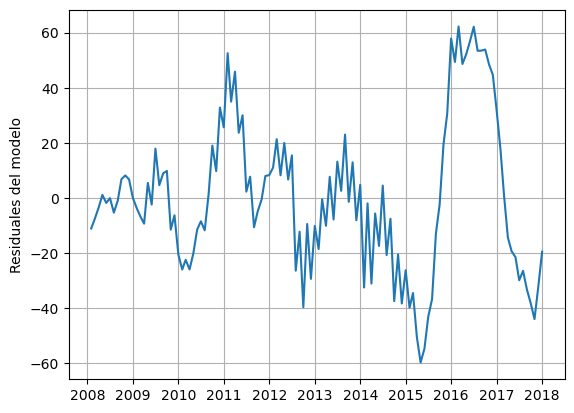

In [127]:
plt.ylabel("Residuales del modelo")
plt.plot(pol_3.resid)
plt.grid()

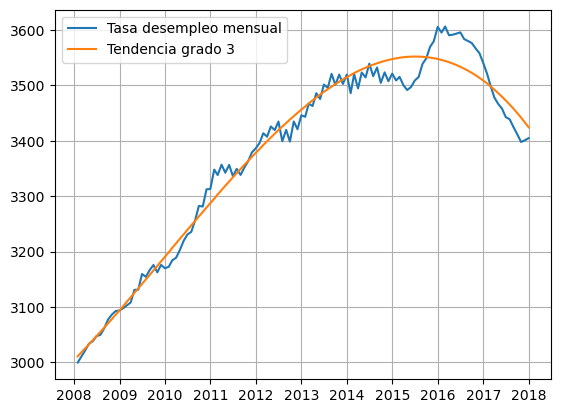

In [128]:
plt.plot(y,label="Tasa desempleo mensual")
plt.plot(pol_3.fittedvalues,label="Tendencia grado 3")
plt.legend()
plt.grid()
plt.show()

In [129]:
h=7
x_for= np.linspace((train_p2.shape[0]+1),(train_p2.shape[0]+h),h)
X_for= sm.add_constant(np.stack((x_for, x_for**2, x_for**3), axis=1))

In [130]:
dt = pol_3.get_prediction(X_for).summary_frame(alpha=0.05)
y_prd = dt["mean"]
yprd_ci_lower = dt["obs_ci_lower"]
yprd_ci_upper = dt["obs_ci_upper"]
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ["Point_forecast", "lower_95", "upper_95"]
print(preds)

   Point_forecast     lower_95     upper_95
0     3415.194796  3356.577804  3473.811787
1     3405.528898  3346.433425  3464.624371
2     3395.493274  3335.867510  3455.119038
3     3385.084130  3324.873030  3445.295229
4     3374.297670  3313.442969  3435.152372
5     3363.130102  3301.570342  3424.689862
6     3351.577630  3289.248218  3413.907042


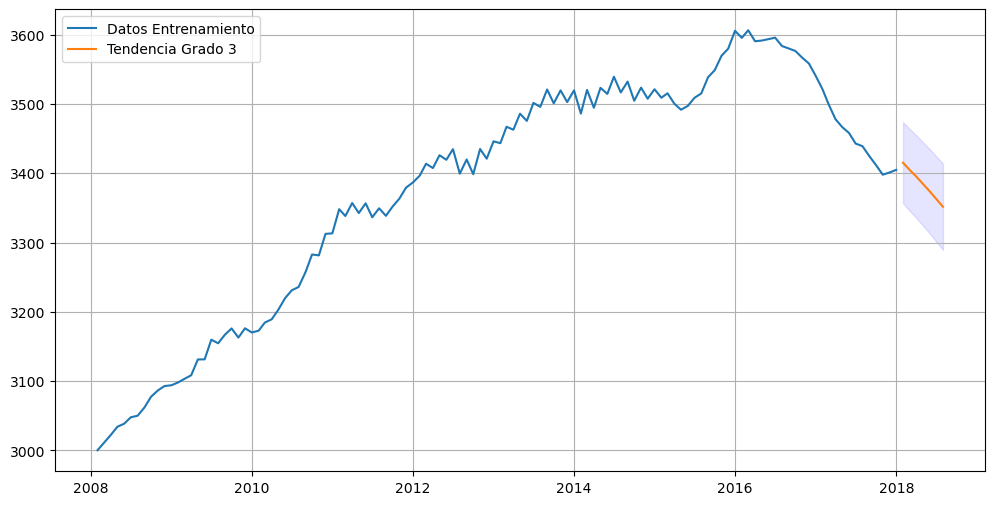

In [131]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p2.index,train_p2.producto2,label="Datos Entrenamiento")
plt.plot(test_p2.index,preds['Point_forecast'],label="Tendencia Grado 3")
plt.fill_between(test_p2.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [132]:
rmse_grado3 = np.sqrt(mean_squared_error(test_p2.producto2, preds['Point_forecast']))

print(f"RMSE: {rmse_grado3}")

RMSE: 73.58911534160558


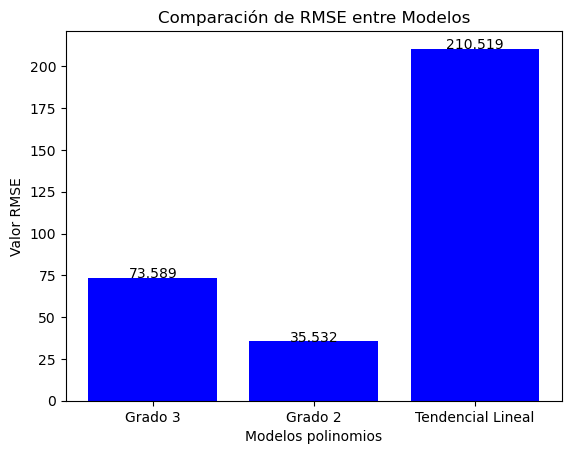

In [133]:
model_labels = ['Grado 3', 'Grado 2', 'Tendencial Lineal']
rmse_values = [rmse_grado3, rmse_grado2, rmse_tendencial_lineal]

# Crear el gráfico de barras
plt.bar(model_labels, rmse_values, color='blue')

# Agregar etiquetas y título
plt.xlabel('Modelos polinomios')
plt.ylabel('Valor RMSE')
plt.title('Comparación de RMSE entre Modelos')

# Agregar etiquetas a las barras
for i in range(len(model_labels)):
    plt.text(i, rmse_values[i] + 0.01, f'{rmse_values[i]:.3f}', ha='center')

# Mostrar el gráfico
plt.show()

### Promedio Movil

In [134]:
train_len = 127-7
train_p1 = data[["producto1"]][:train_len]
test_p1 = data[["producto1"]][train_len:]

In [135]:
## Considerando el dato actual
ma_2= train_p2.rolling(2,min_periods=2).mean()
ma_3= train_p2.rolling(3,min_periods=2).mean()
ma_4= train_p2.rolling(4,min_periods=2).mean()
ma_5= train_p2.rolling(5,min_periods=2).mean()

In [136]:
## Sin considerar el dato actual
ma_2= train_p1.shift().rolling(2,min_periods=2).mean()
ma_3= train_p1.shift().rolling(3,min_periods=2).mean()
ma_4= train_p1.shift().rolling(4,min_periods=2).mean()
ma_5= train_p1.shift().rolling(5,min_periods=2).mean()

In [137]:
ma_2_f= fore_ma(train_p2,2,7)
ma_3_f= fore_ma(train_p2,3,7)
ma_4_f= fore_ma(train_p2,4,7)
ma_5_f= fore_ma(train_p2,5,7)

In [138]:
rmse_ma_2 = np.sqrt(mean_squared_error(test_p2,ma_2_f ))
rmse_ma_3 = np.sqrt(mean_squared_error(test_p2,ma_3_f ))
rmse_ma_4 = np.sqrt(mean_squared_error(test_p2,ma_4_f ))
rmse_ma_5 = np.sqrt(mean_squared_error(test_p2,ma_5_f ))

In [139]:
print( rmse_ma_2, rmse_ma_3 ,rmse_ma_4 ,rmse_ma_5)

45.86859843395978 46.901549711705435 46.40098566650152 44.86589051305315


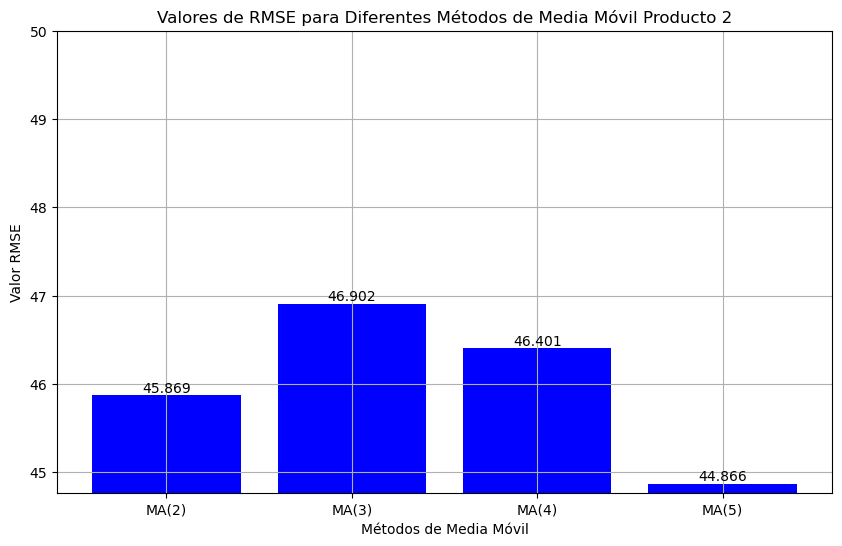

In [140]:
methods = ['MA(2)', 'MA(3)', 'MA(4)', 'MA(5)']

rmse_values = [rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, rmse_values, color='blue')
plt.xlabel('Métodos de Media Móvil')
plt.ylabel('Valor RMSE')
plt.title('Valores de RMSE para Diferentes Métodos de Media Móvil Producto 2')
plt.ylim(min(rmse_values) - 0.1, 50)  

for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{value:.3f}', ha='center', va='bottom')

plt.grid()
plt.show()

El promedio movil con el mejor RMSE es el promedio movil con una ventana de 5 (RMSE = "44.86589051305315")

###  Suavizacion Exponencial Simple

In [141]:
# Construccion del modelo.
ets_model = ETSModel(endog=train_p2["producto2"],error="add")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(7)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds = pd.concat([limits, conf_forecast], axis = 1)
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds)

            Point_forecast     lower_95     upper_95
2018-01-31     3404.439554  3373.310226  3435.568881
2018-02-28     3404.439554  3362.922533  3445.956575
2018-03-31     3404.439554  3354.657116  3454.221991
2018-04-30     3404.439554  3347.580789  3461.298318
2018-05-31     3404.439554  3341.292526  3467.586581
2018-06-30     3404.439554  3335.576101  3473.303006
2018-07-31     3404.439554  3330.299125  3478.579982


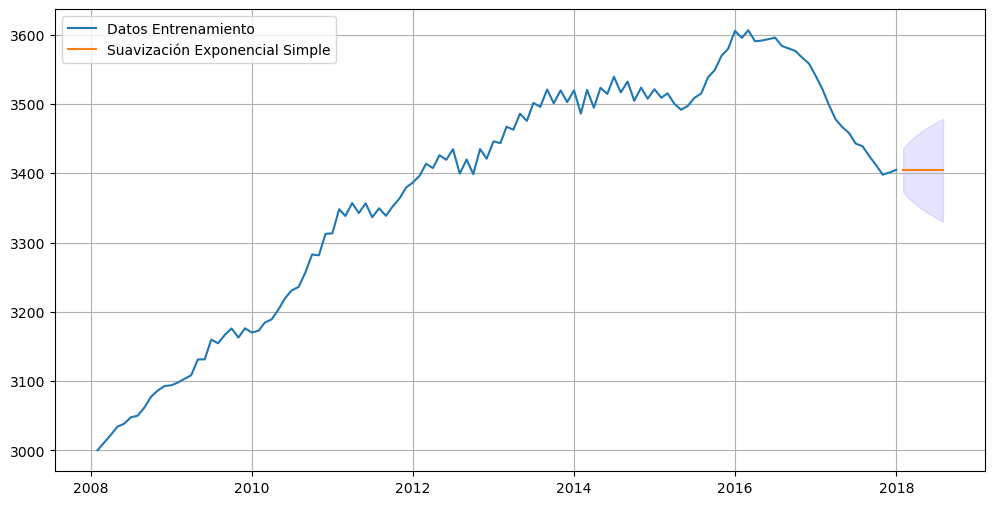

In [142]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p2.producto2,label="Datos Entrenamiento")
plt.plot(preds['Point_forecast'],label="Suavización Exponencial Simple")
plt.fill_between(preds.index ,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [143]:
ets_result.alpha

0.8824634497556372

In [144]:
rmse_simple = np.sqrt(mean_squared_error(test_p2,point_forecast ))
print(rmse_simple)

45.14800217586516


### Suavizacion Exponencial Lineal (Holt)

In [145]:
#Construccion del modelo.
ets_model = ETSModel(endog=train_p2["producto2"],error="mul",trend="mul")
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(7)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds_holt = pd.concat([limits, conf_forecast], axis = 1)
preds_holt.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_holt)

            Point_forecast     lower_95     upper_95
2018-01-31     3396.878534  3370.365657  3424.150936
2018-02-28     3398.264085  3362.182504  3435.287883
2018-03-31     3399.650202  3347.081104  3451.369783
2018-04-30     3401.036885  3326.340248  3474.318038
2018-05-31     3402.424133  3306.407703  3500.292990
2018-06-30     3403.811947  3282.984124  3525.883752
2018-07-31     3405.200326  3261.234101  3551.633579


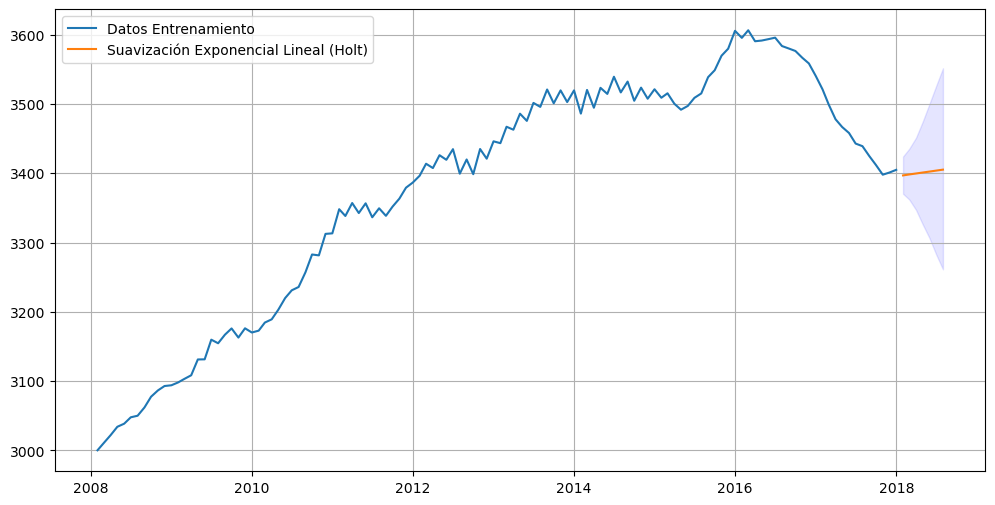

In [146]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p2,label="Datos Entrenamiento")
plt.plot(preds_holt['Point_forecast'],label="Suavización Exponencial Lineal (Holt)")
plt.fill_between(preds_holt.index ,preds_holt['lower_95'], preds_holt['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [147]:
print(ets_result.alpha,ets_result.beta)

0.4952813377178475 0.47744803698987925


In [148]:
rmse_holt = np.sqrt(mean_squared_error(test_p2,preds_holt['Point_forecast']))
print(rmse_holt)

46.878861361125544


En esta caso el α estimado es 0.49451111842055 y el β estimado es 0.49446166730870794. Y el RMSE en la muestra de evaluación es 46.878861361125544.

### Suavizacion Exponencial Lineal de Winters (Holt-Winters)

In [149]:
#Construccion del modelo ADIVITVO.
ets_model = ETSModel(endog=train_p2["producto2"],error="add",trend="add",seasonal="add" )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(7)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds_hw_add = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_add.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_add)

            Point_forecast     lower_95     upper_95
2018-01-31     3389.753337  3365.269885  3414.236788
2018-02-28     3394.027918  3359.121872  3428.933963
2018-03-31     3384.765846  3333.666737  3435.864956
2018-04-30     3389.016935  3317.693968  3460.339903
2018-05-31     3385.673307  3291.040134  3480.306481
2018-06-30     3390.905029  3270.381174  3511.428885
2018-07-31     3381.057906  3232.369919  3529.745894


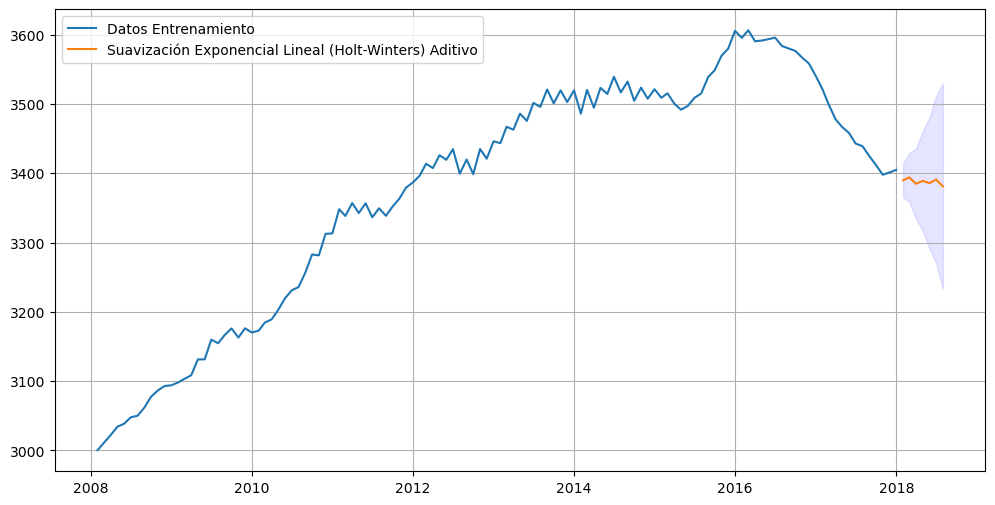

In [150]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p2,label="Datos Entrenamiento")
plt.plot(preds_hw_add['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Aditivo")
plt.fill_between(preds_hw_add.index ,preds_hw_add['lower_95'], preds_hw_add['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [151]:
print(ets_result.alpha,ets_result.beta,ets_result.gamma)

0.5081147607073613 0.5080639492312905 4.9188523929263876e-05


In [152]:
rmse_hw_add = np.sqrt(mean_squared_error(test_p2,preds_hw_add['Point_forecast']))
print(rmse_hw_add)

60.84617123630382


In [153]:
#Construccion del modelo MULTIPLICATIVO.
ets_model = ETSModel(endog=train_p2["producto2"],error="add",trend=None,seasonal="mul" , )
ets_result = ets_model.fit()

point_forecast=ets_result.forecast(7)

ci = ets_result.get_prediction(start = point_forecast.index[0],
                                end = point_forecast.index[-1])

conf_forecast = ci.pred_int(alpha=0.05)
limits = ci.predicted_mean


preds_hw_mul = pd.concat([limits, conf_forecast], axis = 1)
preds_hw_mul.columns = ['Point_forecast', 'lower_95', 'upper_95']
print(preds_hw_mul)

            Point_forecast     lower_95     upper_95
2018-01-31     3398.030083  3365.386764  3429.903067
2018-02-28     3403.471473  3361.235679  3443.112257
2018-03-31     3394.854128  3346.037156  3446.260477
2018-04-30     3400.154324  3340.577090  3458.024660
2018-05-31     3397.696971  3329.528899  3461.529763
2018-06-30     3403.873384  3328.608063  3472.078691
2018-07-31     3394.624905  3315.509556  3469.851336


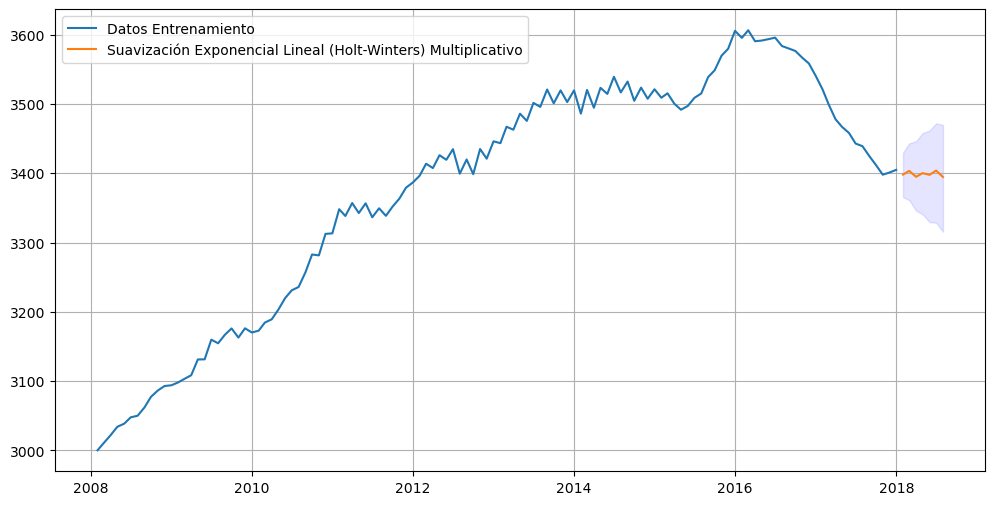

In [154]:
fig = plt.figure(figsize=(12, 6))
plt.plot(train_p2,label="Datos Entrenamiento")
plt.plot(preds_hw_mul['Point_forecast'],label="Suavización Exponencial Lineal (Holt-Winters) Multiplicativo")
plt.fill_between(preds_hw_mul.index ,preds_hw_mul['lower_95'], preds_hw_mul['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [155]:
print(ets_result.alpha,ets_result.gamma)

0.9165945110910177 8.340548890898226e-06


In [156]:
rmse_hw_mul = np.sqrt(mean_squared_error(test_p2,preds_hw_mul['Point_forecast']))
print(rmse_hw_mul)

50.116873745099504


In [157]:
train_len = 127-7
train_p2 = data[["producto2"]][:train_len]
test_p2 = data[["producto2"]][train_len:]

In [158]:
test_p2

,producto2
2018-01-31,3410.997204
2018-02-28,3424.502102
2018-03-31,3429.293034
2018-04-30,3437.099467
2018-05-31,3453.155282
2018-06-30,3472.528345
2018-07-31,3476.058092


In [159]:
def train_and_evaluate_RMSE(error,trend,seasonal,alpha,beta,gamma):
    """Function we want to maximize (Black box)

    It first trains a model with the training set using the received hyper
    parameterts, and then evaluatesand returns the Min RMSE over the test set.
    """

    alpha = round(alpha,2)
    beta  = round(beta,2)
    gamma = round(gamma,2)

    print(error,trend,seasonal)
    print(alpha,beta,gamma)
    error1 = ["add","mul"]
    trend1 = ["add","mul",None]
    seasonal1 = ["add","mul",None]

    model = ETSModel(endog=train_p2["producto2"],error=error1[round(error)],trend=trend1[round(trend)],seasonal=seasonal1[round(seasonal)])

    params = {'smoothing_level': alpha,'smoothing_trend': beta,'smoothing_seasonal':gamma}

    if trend1[round(trend)] == None:
      params.pop('smoothing_trend')
    if seasonal1[round(seasonal)] == None:
      params.pop('smoothing_seasonal')

    model_result = model.fit_constrained(params)

    point_forecast=model_result.forecast(7)
    rmse = np.sqrt(mean_squared_error(test_p2["producto2"],point_forecast ))

    print(" target es: {},Eror test: {},Trend test: {},Seasonal test: {},Alpha model: {},Beta model: {}, Gamma model: {}".
          format(rmse,error1[round(error)],trend1[round(trend)],seasonal1[round(seasonal)],alpha,beta,gamma))

    return -rmse

In [160]:
pbounds = {'error':  (0,1),'trend':(0,2) , 'seasonal': (0,2), 'alpha':(0.01,0.99) , "beta" :(0.01,0.99),"gamma" :(0.01,0.99) }

In [161]:
optimizer = BayesianOptimization(
    f=train_and_evaluate_RMSE,
    pbounds=pbounds,
    random_state=1,
    verbose=2
)

In [162]:
import warnings
warnings.filterwarnings("ignore")
optimizer.maximize(init_points=3, n_iter=100)

|   iter    |  target   |   alpha   |   beta    |   error   |   gamma   | seasonal  |   trend   |
-------------------------------------------------------------------------------------------------
0.00011437481734488664 0.1846771895375956 0.2935117816342261
0.42 0.72 0.31
 target es: 50.583791429926386,Eror test: add,Trend test: add,Seasonal test: add,Alpha model: 0.42,Beta model: 0.72, Gamma model: 0.31
| 1         | -50.58    | 0.4187    | 0.7159    | 0.0001144 | 0.3063    | 0.2935    | 0.1847    |
0.39676747423066994 1.370439000793519 0.8383890288065896
0.19 0.35 0.54
 target es: 85.27847152895833,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.19,Beta model: 0.35, Gamma model: 0.54
| 2         | -85.28    | 0.1925    | 0.3486    | 0.3968    | 0.538     | 0.8384    | 1.37      |
0.027387593197926163 1.1173796568915033 0.8346096047342539
0.21 0.87 0.67
 target es: 17.822620008259197,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.21,Beta model: 0.87, 

0.016525687657107158 0.45412804012695984 1.8779319052122936
0.02 0.64 0.88
 target es: 122.95108324118875,Eror test: add,Trend test: add,Seasonal test: None,Alpha model: 0.02,Beta model: 0.64, Gamma model: 0.88
| 24        | -123.0    | 0.02419   | 0.6378    | 0.01653   | 0.8803    | 1.878     | 0.4541    |
0.5311869646531169 1.0154856675233124 0.5634003343863672
0.06 0.54 0.04
 target es: 67.67694506504637,Eror test: mul,Trend test: mul,Seasonal test: mul,Alpha model: 0.06,Beta model: 0.54, Gamma model: 0.04
| 25        | -67.68    | 0.06227   | 0.5443    | 0.5312    | 0.04278   | 0.5634    | 1.015     |
0.8110396677477442 1.4241358595007716 1.7520329159770418
0.48 0.76 0.78
 target es: 8.579699885990228,Eror test: mul,Trend test: mul,Seasonal test: None,Alpha model: 0.48,Beta model: 0.76, Gamma model: 0.78
| 26        | -8.58     | 0.4837    | 0.7552    | 0.811     | 0.7754    | 1.752     | 1.424     |
0.5072040583559912 0.31205275106117414 0.05795197906142735
0.38 0.09 0.43
 target 

0.9593224018642393 0.9926171537664589 1.2476172409517177
0.01 0.79 0.95
 target es: 30654195948.887722,Eror test: mul,Trend test: mul,Seasonal test: mul,Alpha model: 0.01,Beta model: 0.79, Gamma model: 0.95
| 47        | -3.065e+1 | 0.01      | 0.7925    | 0.9593    | 0.9477    | 1.248     | 0.9926    |
0.40023299864164685 0.49802772568400777 1.007815053437854
0.92 0.77 0.02
 target es: 43.8457655096323,Eror test: add,Trend test: add,Seasonal test: mul,Alpha model: 0.92,Beta model: 0.77, Gamma model: 0.02
| 48        | -43.85    | 0.9243    | 0.7714    | 0.4002    | 0.02447   | 1.008     | 0.498     |
0.6142592217621343 0.3079241803870598 1.039731071794391
0.43 0.63 0.45
 target es: 34.78981227690292,Eror test: mul,Trend test: add,Seasonal test: mul,Alpha model: 0.43,Beta model: 0.63, Gamma model: 0.45
| 49        | -34.79    | 0.4295    | 0.6255    | 0.6143    | 0.4539    | 1.04      | 0.3079    |
0.9458876838394873 0.9022577768512603 0.03351368209155381
0.92 0.09 0.99
 target es: 84.

0.7175485390923516 1.8090415084234974 0.7938462517824348
0.94 0.32 0.59
 target es: 50.42221480474892,Eror test: mul,Trend test: None,Seasonal test: mul,Alpha model: 0.94,Beta model: 0.32, Gamma model: 0.59
| 70        | -50.42    | 0.944     | 0.3199    | 0.7175    | 0.5943    | 0.7938    | 1.809     |
0.9835499981084895 0.10333217370572309 1.5908861051590555
0.51 0.17 0.74
 target es: 80.4259932542247,Eror test: mul,Trend test: add,Seasonal test: None,Alpha model: 0.51,Beta model: 0.17, Gamma model: 0.74
| 71        | -80.43    | 0.5073    | 0.1704    | 0.9835    | 0.7367    | 1.591     | 0.1033    |
0.25150183672163007 1.6226382670764996 1.5594727865738023
0.04 0.03 0.59
 target es: 48.43287812022961,Eror test: add,Trend test: None,Seasonal test: None,Alpha model: 0.04,Beta model: 0.03, Gamma model: 0.59
| 72        | -48.43    | 0.04452   | 0.0299    | 0.2515    | 0.5925    | 1.559     | 1.623     |
0.0782032190399079 1.8513281123656677 0.6444555574807818
0.42 0.42 0.43
 target es:

0.7586390310177874 1.4293148438115493 1.7714799687207852
0.52 0.74 0.82
 target es: 12.418052413741334,Eror test: mul,Trend test: mul,Seasonal test: None,Alpha model: 0.52,Beta model: 0.74, Gamma model: 0.82
| 93        | -12.42    | 0.5176    | 0.7392    | 0.7586    | 0.8176    | 1.771     | 1.429     |
0.0 0.8356117713327368 0.8468940693237247
0.07 0.7 0.33
 target es: 30.22181005700181,Eror test: add,Trend test: mul,Seasonal test: mul,Alpha model: 0.07,Beta model: 0.7, Gamma model: 0.33
| 94        | -30.22    | 0.06784   | 0.6979    | 0.0       | 0.3255    | 0.8469    | 0.8356    |
0.5929523255865321 0.3494404547220664 0.43346710238518305
0.54 0.64 0.36
 target es: 57.22755482150485,Eror test: mul,Trend test: add,Seasonal test: add,Alpha model: 0.54,Beta model: 0.64, Gamma model: 0.36
| 95        | -57.23    | 0.5361    | 0.6403    | 0.593     | 0.3562    | 0.4335    | 0.3494    |
0.7778866493475013 0.926607607270819 0.7165845762572502
0.13 0.32 0.56
 target es: 93.18378081556496,E

In [163]:
optimal_values = optimizer.max
print("Valor RMSE:", -optimal_values['target'])
print("Parámetros óptimos:", optimal_values['params'])

Valor RMSE: 3.850504356039672
Parámetros óptimos: {'alpha': 0.32337435151163035, 'beta': 0.99, 'error': 0.0, 'gamma': 0.3767570546798793, 'seasonal': 1.3174138223925602, 'trend': 0.4505494442586482}


In [164]:
rmse_Optimizado=-optimal_values['target']

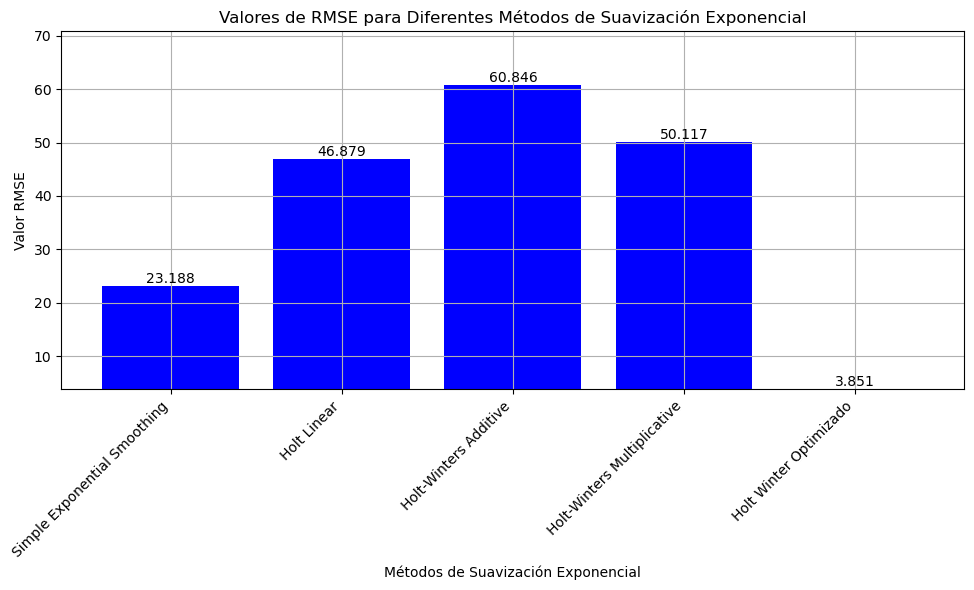

In [165]:
# Nombres de los métodos
methods = ['Simple Exponential Smoothing', 'Holt Linear', 'Holt-Winters Additive', 'Holt-Winters Multiplicative', 'Holt Winter Optimizado']

# Valores RMSE correspondientes
rmse_values = [rmse_simple, rmse_holt, rmse_hw_add, rmse_hw_mul, rmse_Optimizado]

# Crear el gráfico
plt.figure(figsize=(10, 6))
bars = plt.bar(methods, rmse_values, color='blue')
plt.xlabel('Métodos de Suavización Exponencial')
plt.ylabel('Valor RMSE')
plt.title('Valores de RMSE para Diferentes Métodos de Suavización Exponencial')
plt.ylim(min(rmse_values) - 0.1, max(rmse_values) + 10)

# Agregar los valores encima de las barras
for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{value:.3f}', ha='center', va='bottom')

# Rotar los nombres de los métodos en el eje x para mayor legibilidad
plt.xticks(rotation=45, ha='right')

# Mostrar el gráfico
plt.grid()
plt.tight_layout()  # Ajustar el diseño
plt.show()


### Auto arima

In [166]:
model = auto_arima(train_p2["producto2"],max_p=10, max_q=10,information_criterion = ("aic"))
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(2, 2, 1)   Log Likelihood                -437.492
Date:                Tue, 29 Aug 2023   AIC                            882.983
Time:                        21:19:51   BIC                            894.066
Sample:                    01-31-2008   HQIC                           887.483
                         - 12-31-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1185      0.103     -1.153      0.249      -0.320       0.083
ar.L2          0.7130      0.108      6.581      0.000       0.501       0.925
ma.L1         -0.9634      0.056    -17.312      0.000      -1.072      -0.854
sigma2        95.0732     12.334      7.708      0.000      70.898     119.248
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 0.49
Prob(Q):                              0.92   Prob(JB):                         0.78
Heteroskedasticity (H):               1.04   Skew:                            -0.14
Prob(H) (two-sided):                  0.91   Kurtosis:                         3.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

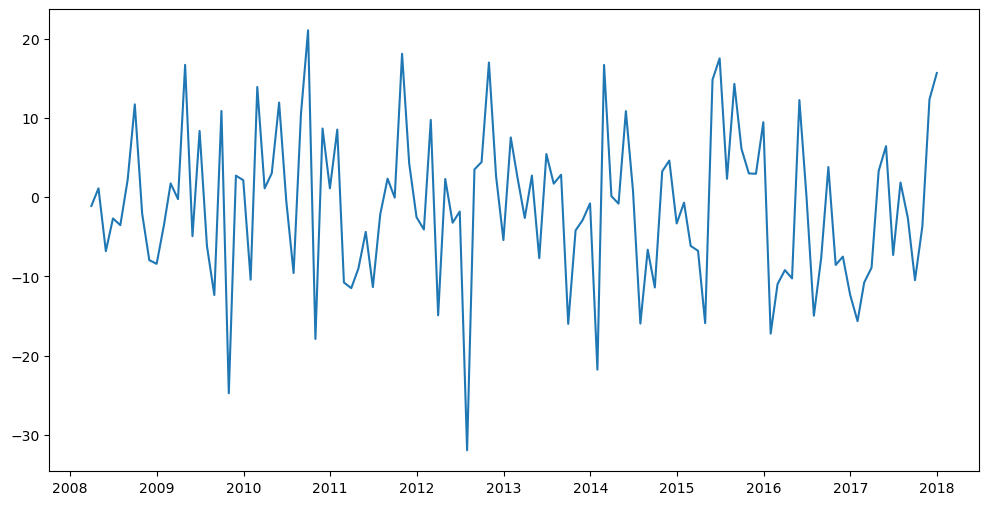

In [167]:
fig = plt.figure(figsize=(12, 6))
plt.plot(model.resid()[2:],label="Residuales")

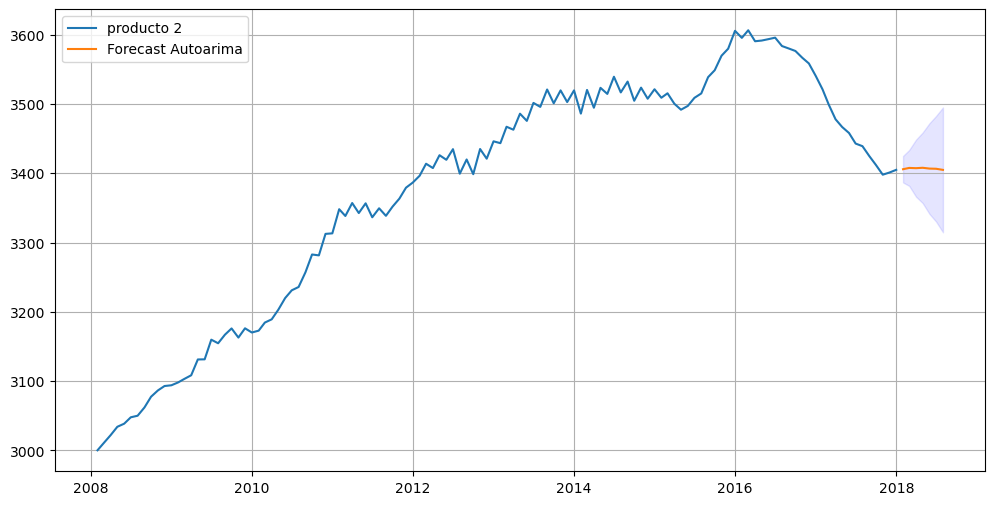

In [168]:
h=7

y_forec, conf_int  = model.predict(h,return_conf_int=True,alpha=0.05)
preds = pd.DataFrame(np.column_stack([y_forec,conf_int[:,0] , conf_int[:,1]]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']


fig = plt.figure(figsize=(12, 6))
plt.plot(train_p2.index,train_p2["producto2"],label="producto 2")
plt.plot(test_p2.index,preds['Point_forecast'],label="Forecast Autoarima")
plt.fill_between(test_p2.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [169]:
rmse_autoarima = np.sqrt(mean_squared_error(test_p2["producto2"], preds["Point_forecast"]))
rmse_autoarima

43.472437504988335

In [170]:
window_size = 120  # Tamaño de la ventana de entrenamiento y pronóstico
forecast_steps = 1  # Número de pasos de pronóstico


for i in range(0, 7):
    # Definir los conjuntos de entrenamiento y prueba
    train_subset = train_p2["producto2"][:i+window_size]
    test_subset = test_p2["producto2"][i:i+forecast_steps]  # Corregir la selección del conjunto de prueba
    # Ajustar el modelo SARIMA con los órdenes y valores estacionales definidos
    model = SARIMAX(train_subset, order=(2, 2, 1), seasonal_order=model.seasonal_order)
    model_fit = model.fit()
    
    # Realizar pronósticos
    forecast = model_fit.forecast(steps=forecast_steps)
    
    # Calcular el RMSE
    rmse = mean_squared_error(test_subset, forecast, squared=False)
    print(f"Pronostico {i+1}: RMSE = {rmse}")

Pronostico 1: RMSE = 5.167232531978698
Pronostico 2: RMSE = 18.672131149709003
Pronostico 3: RMSE = 23.463062845638888
Pronostico 4: RMSE = 31.269496106508996
Pronostico 5: RMSE = 47.32531080494891
Pronostico 6: RMSE = 66.6983737156188
Pronostico 7: RMSE = 70.22812108628887


## Validacion de supuestos para modelo arima

## Autocorrelacion
Autocorrelación
Para determinar si existe autocorrelación vamos a usar la prueba de rachas propuesta por Wald y Wolfowitz, 1940. Es una prueba no paramétrica donde las hipótesis son las siguientes:

𝐻0:ρ=0
  (Es decir no hay autocorrelación)

𝐻1:ρ≠0
  (Es decir hay autocorrelación)

Rechazo  𝐻0
  cuando el p-valor es menor al nivel de significancia, convencionalmente se usa un  α
 =0.05 ( α
  = nivel de significancia).

In [171]:
result = model.fit()
residuals = result.resid
runstest_1samp(residuals[1:], correction=False)

(0.732041674894759, 0.4641431313971085)

Se puede concluir que No existe autocorrelación en los residuales

### Prueba de Box-Pierce y la modificación de Ljung-Box 

In [172]:
Resul_lb_bp = sm.stats.acorr_ljungbox(residuals[2:], lags=range(1,20), return_df=True,boxpierce=True )
Resul_lb_bp["lb_ho"] = np.where(Resul_lb_bp['lb_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')
Resul_lb_bp["bp_ho"] = np.where(Resul_lb_bp['bp_pvalue']<0.05, 'rechazo_ho/hay_autocorr', 'no_rechazo_ho/no_hay_autocorr')

Resul_lb_bp

,lb_stat,lb_pvalue,bp_stat,bp_pvalue,lb_ho,bp_ho
1,0.007511,0.930935,0.007324,0.931801,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
2,0.016289,0.991888,0.015809,0.992127,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
3,0.108210,0.990834,0.103900,0.991365,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
4,0.753042,0.944630,0.716490,0.949280,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
5,2.151927,0.827749,2.033774,0.844452,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
6,2.162264,0.904187,2.043421,0.915662,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
7,2.615633,0.918141,2.462787,0.929873,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
8,2.781963,0.947287,2.615256,0.956140,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
9,2.861009,0.969551,2.687057,0.975423,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr
10,3.236448,0.975299,3.024951,0.980831,no_rechazo_ho/no_hay_autocorr,no_rechazo_ho/no_hay_autocorr


In [173]:
result = model.fit()
residuals = result.resid

# Calcular el estadístico de Durbin-Watson
durbin_watson_statistic = durbin_watson(residuals[2:])

print(f"Estadístico de Durbin-Watson: {durbin_watson_statistic}")


Estadístico de Durbin-Watson: 1.9342535231694413


Para el Producto  2 se evidencia una No autocorrelacion en los residuales por lo tanto si se cumple el supuesto

###  Homoscedasticidad y Heteroscedasticidad**

Ahora nos queda por chequear si existe problemas de heteroscedasticidad, en
especial un comportamiento tipo ARCH o GARCH, esto implica que la varianza de la serie tenga un comportamiento no autocorrelacionado.

Una aproximación para determinar si existe un comportamiento GARCH o
ARCH es emplear la prueba de Ljung-Box sobre la serie (sin media) al cuadrado.

$H{0}:$ Comportamiento Homoscedastico (Es decir varianza constante) 

$H{1}:$ Comportamiento Heteroscedastico (Es decir varianza no constante)

In [174]:
sm.stats.acorr_ljungbox((residuals[2:]-residuals[2:].mean())**2, lags=range(1,21), return_df=True,boxpierce=True )

,lb_stat,lb_pvalue,bp_stat,bp_pvalue
1,0.001661,0.967493,0.001619,0.967902
2,1.420832,0.491440,1.373485,0.503213
3,1.540585,0.672935,1.488248,0.684985
4,2.344880,0.672610,2.252329,0.689461
5,2.709670,0.744639,2.595839,0.761997
6,3.287702,0.771967,3.135336,0.791679
7,3.691271,0.814571,3.508636,0.834310
8,4.585138,0.800856,4.328014,0.826383
9,4.789451,0.852262,4.513599,0.874484
10,6.958205,0.729385,6.465478,0.774758


Los resultados del la Tabla anterior, permiten aceptar la hipotesis nula de un comportamiento homoscedástico

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


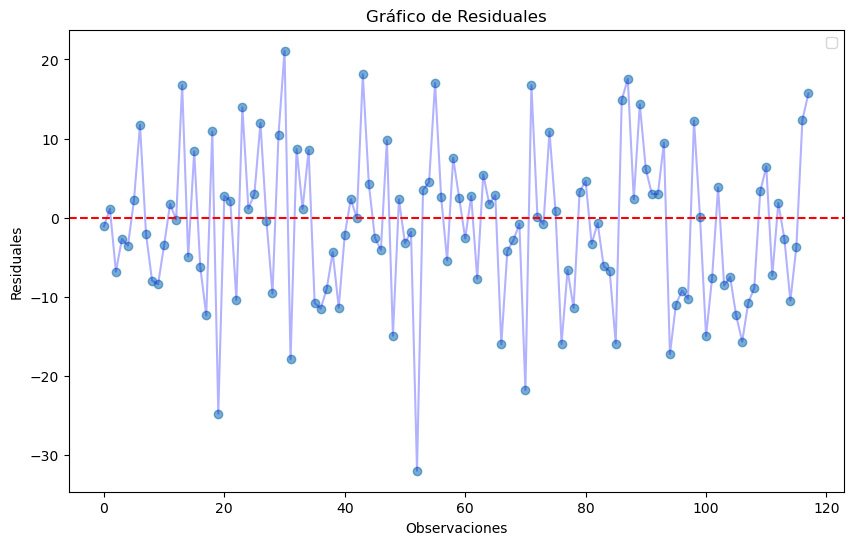

In [175]:
result = model.fit()
residuals = result.resid

# Crear un gráfico de dispersión de los residuales
plt.figure(figsize=(10, 6))
plt.scatter(range(len(residuals[2:])), residuals[2:], alpha=0.6)
plt.plot(range(len(residuals[2:])), residuals[2:], 'b-', alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gráfico de Residuales')
plt.xlabel('Observaciones')
plt.ylabel('Residuales')
plt.legend()
plt.show()


se puede comprobar con la grafica que los residuales tienen un comportamiento homocedastico

### prueba de normalidad

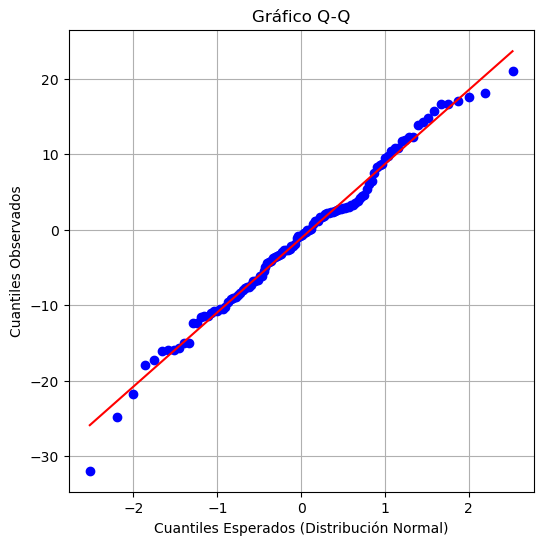

In [176]:
plt.figure(figsize=(6, 6))
stats.probplot(residuals[2:], plot=plt)
plt.xlabel('Cuantiles Esperados (Distribución Normal)')
plt.ylabel('Cuantiles Observados')
plt.title('Gráfico Q-Q')
plt.grid(True)
plt.show()

In [177]:
statistic, p_value = stats.shapiro(residuals[2:])

print("Estadística de prueba:", statistic)
print("Valor p:", p_value)

alpha = 0.05
if p_value > alpha:
    print("Los datos siguen una distribución normal (no se rechaza la hipótesis nula).")
else:
    print("Los datos no siguen una distribución normal (se rechaza la hipótesis nula).")

Estadística de prueba: 0.989845871925354
Valor p: 0.5333203673362732
Los datos siguen una distribución normal (no se rechaza la hipótesis nula).


### Estacionalidad + tendencia

In [178]:
train_len = 127-7
train_p1 = data[["producto1"]][:train_len]
test_p1 = data[["producto1"]][train_len:]

In [179]:
y = train_p2["producto2"]
train_p2["q"] = np.linspace(1,train_p2.shape[0],train_p2.shape[0])
train_p2["q2"] = train_p2["q"]**2
train_p2["q3"] = train_p2["q"]**3

month_dummies = pd.get_dummies(train_p2.index.month,drop_first=True).set_index(train_p2.index)
X = sm.add_constant( pd.concat([train_p2[["q","q2","q3"]],month_dummies],axis=1) )

season_pol3 = sm.OLS(y,X)
season_pol_3 = season_pol3.fit()
print(season_pol_3.summary())

                            OLS Regression Results                            
Dep. Variable:              producto2   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.972
Method:                 Least Squares   F-statistic:                     292.3
Date:                Tue, 29 Aug 2023   Prob (F-statistic):           2.98e-77
Time:                        21:19:55   Log-Likelihood:                -565.88
No. Observations:                 120   AIC:                             1162.
Df Residuals:                     105   BIC:                             1204.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3004.1692     13.564    221.481      0.0

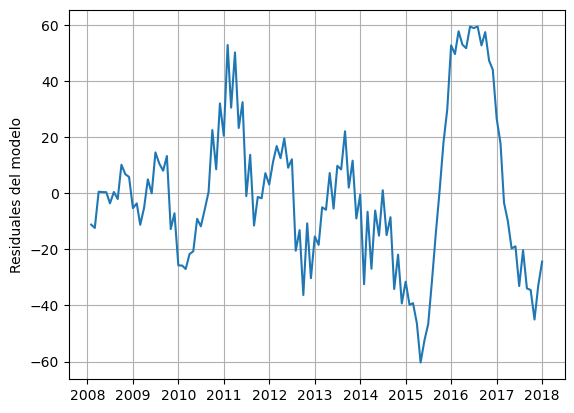

In [180]:
plt.ylabel("Residuales del modelo")
plt.plot(season_pol_3.resid)
plt.grid()

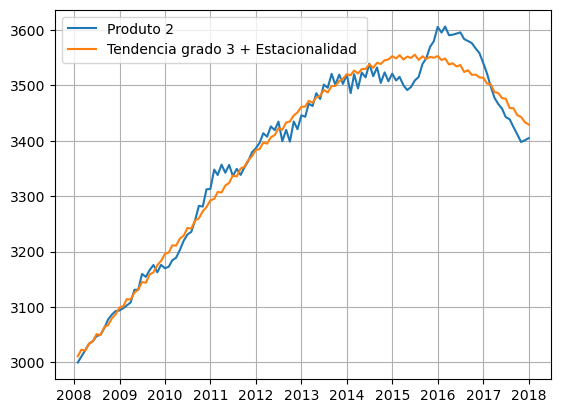

In [181]:
plt.plot(y,label="Produto 2")
plt.plot(season_pol_3.fittedvalues,label="Tendencia grado 3 + Estacionalidad ")
plt.legend()
plt.grid()

In [182]:
h=12
x_for= np.linspace((train_p2.shape[0]+1),(train_p2.shape[0]+h),h)
x_for_all = pd.DataFrame(np.stack((x_for, x_for**2, x_for**3),axis=1),columns=["x","x2", "x3"] )

range_dates = pd.date_range(train_p2.index[-1]+ relativedelta(months=1), periods=h,freq='M')
x_for_dummies = pd.get_dummies(range_dates.month,drop_first=True)

X_for= sm.add_constant(pd.concat([x_for_all,x_for_dummies],axis=1))
X_for

,const,x,x2,x3,2,3,4,5,6,7,8,9,10,11,12
0,1.0,121.0,14641.0,1771561.0,0,0,0,0,0,0,0,0,0,0,0
1,1.0,122.0,14884.0,1815848.0,1,0,0,0,0,0,0,0,0,0,0
2,1.0,123.0,15129.0,1860867.0,0,1,0,0,0,0,0,0,0,0,0
3,1.0,124.0,15376.0,1906624.0,0,0,1,0,0,0,0,0,0,0,0
4,1.0,125.0,15625.0,1953125.0,0,0,0,1,0,0,0,0,0,0,0
5,1.0,126.0,15876.0,2000376.0,0,0,0,0,1,0,0,0,0,0,0
6,1.0,127.0,16129.0,2048383.0,0,0,0,0,0,1,0,0,0,0,0
7,1.0,128.0,16384.0,2097152.0,0,0,0,0,0,0,1,0,0,0,0
8,1.0,129.0,16641.0,2146689.0,0,0,0,0,0,0,0,1,0,0,0
9,1.0,130.0,16900.0,2197000.0,0,0,0,0,0,0,0,0,1,0,0


In [183]:
dt = season_pol_3.get_prediction(X_for).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
preds = pd.DataFrame(np.column_stack([y_prd, yprd_ci_lower, yprd_ci_upper]))
preds.columns = ['Point_forecast', 'lower_95', 'upper_95']
preds.set_index(range_dates,inplace=True)
print(preds.head(7))

            Point_forecast     lower_95     upper_95
2018-01-31     3414.613439  3350.488053  3478.738825
2018-02-28     3409.662477  3345.097348  3474.227605
2018-03-31     3390.788997  3325.739491  3455.838503
2018-04-30     3385.078198  3319.496900  3450.659496
2018-05-31     3371.410827  3305.247543  3437.574110
2018-06-30     3365.956175  3299.157954  3432.754396
2018-07-31     3345.070627  3277.581799  3412.559455


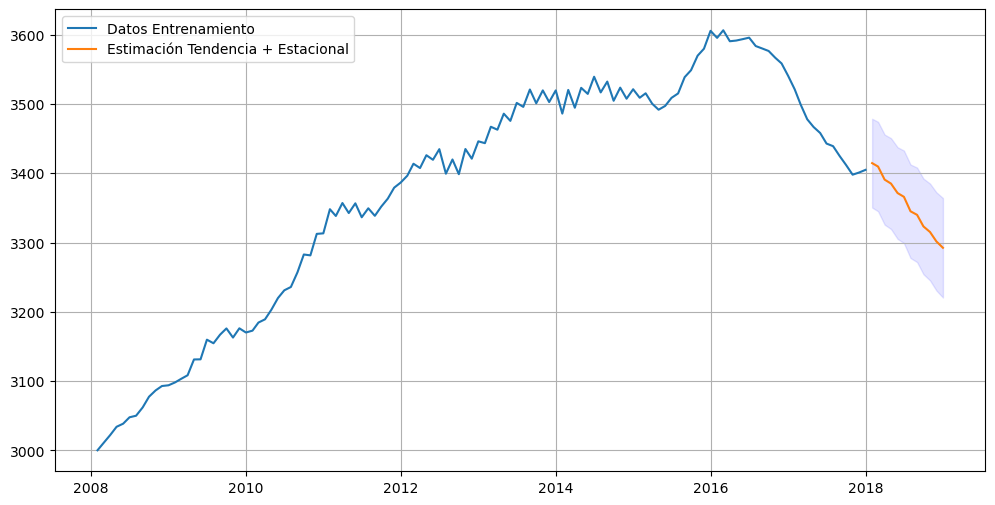

In [184]:
fig = plt.figure(figsize=(12, 6))
plt.plot(y.index,y,label="Datos Entrenamiento")
plt.plot(preds.index,preds['Point_forecast'],label="Estimación Tendencia + Estacional")
plt.fill_between(preds.index,preds['lower_95'], preds['upper_95'], color='blue', alpha=0.1)
plt.legend()
plt.grid()
plt.show()

In [185]:
rmse_S_T = np.sqrt(mean_squared_error(test_p2, preds.Point_forecast.head(7)))
rmse_S_T

75.23255774824611

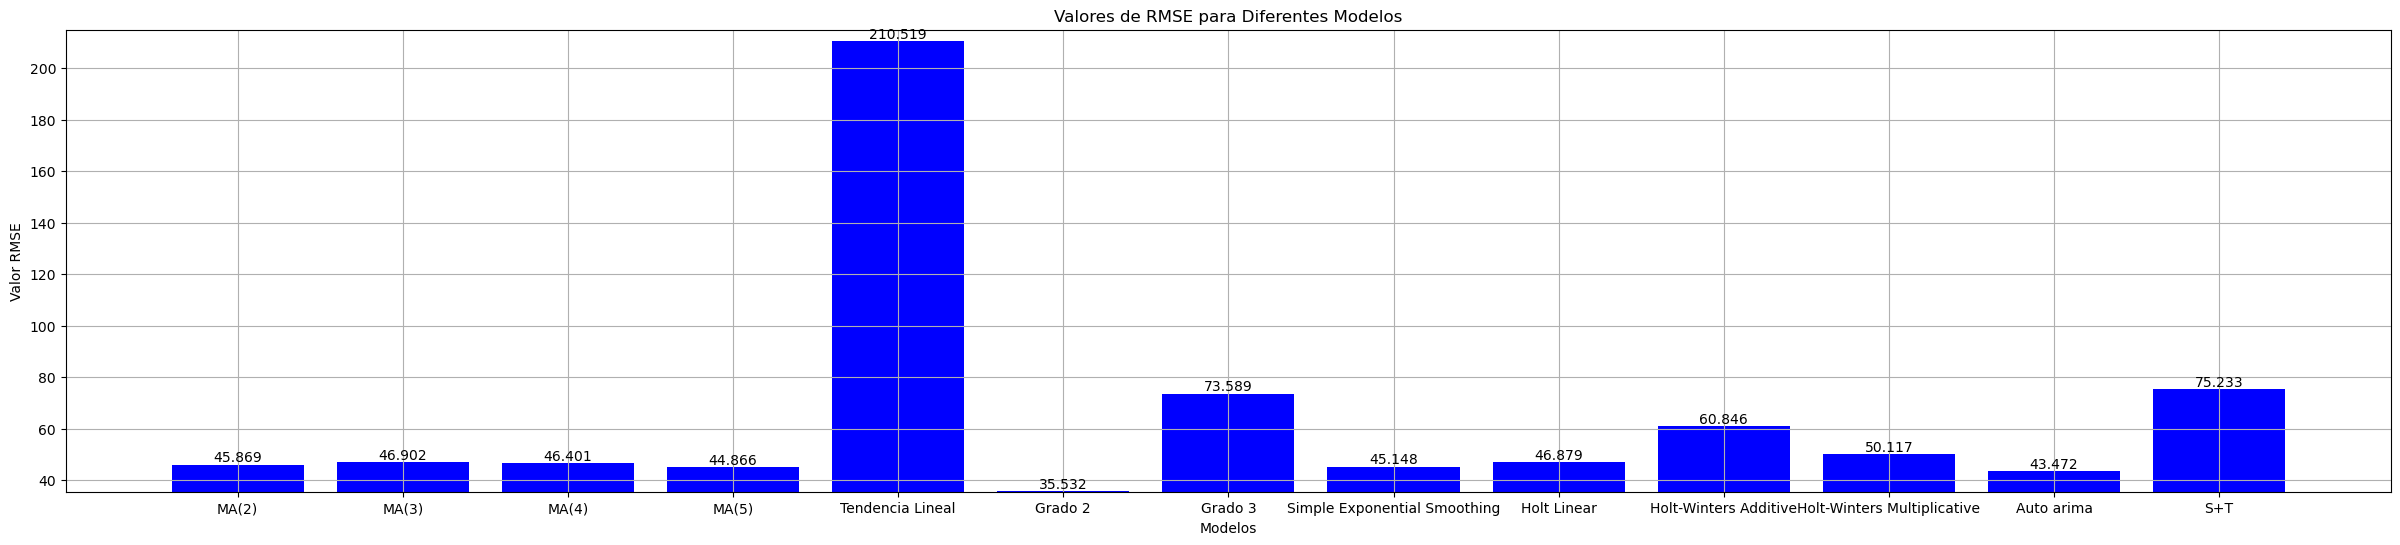

In [186]:
methods = ['MA(2)', 'MA(3)', 'MA(4)', 'MA(5)', 'Tendencia Lineal', 'Grado 2', 'Grado 3', 'Simple Exponential Smoothing', 'Holt Linear', 'Holt-Winters Additive', 'Holt-Winters Multiplicative', 'Auto arima', 'S+T']

rmse_values = [rmse_ma_2, rmse_ma_3, rmse_ma_4, rmse_ma_5, rmse_tendencial_lineal, rmse_grado2, rmse_grado3, rmse_simple, rmse_holt, rmse_hw_add, rmse_hw_mul, rmse_autoarima, rmse_S_T  ]

plt.figure(figsize=(30, 6))
bars = plt.bar(methods, rmse_values, color='blue')
plt.xlabel('Modelos')
plt.ylabel('Valor RMSE')
plt.title('Valores de RMSE para Diferentes Modelos')
plt.ylim(min(rmse_values) - 0.1, 215)  

for bar, value in zip(bars, rmse_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.005, f'{value:.3f}', ha='center', va='bottom')

plt.grid()
plt.show()